<a name="TOC"></a>
# Adiabatic (ground and excited states) dynamics with atomistic systems

## Table of Content: <a name="TOC"></a>

1. [Testing the imported atomistic Hamiltonian](#model-setup)
 
 
2. [Adiabatic dynamics on the ground state](#gs-dynamics)

 2.1. [Initialize nuclear variables](#gs-init-nuclei)
 
 2.2. [Initialize electronic variables](#gs-init-elec)
 
 2.3. [Define the dynamical parameters](#gs-dyn-params)
 
 2.4. [Run the calculations](#gs-run)
 
 2.5. [Plot the properties](#gs-properties)
 
 2.6. [Visualize MD trajectories](#gs-md-vis)


3. [Adiabatic dynamics on the excited state](#ex-dynamics)


## A. Learning objectives

- to set up and execute adiabatic MD on ground and excited states with DFTB+/Libra interface


## B. Use cases

- [Adiabatic MD on ground state with DFTB+](#gs-dynamics)
- [Adiabatic MD on excited state with DFTB+](#ex-dynamics)
- [Initialize initial conditions for the atomistic systems](#gs-init-nuclei) | [also here](#gs-init-elec)
- [Visualize the MD trajectories with py3Dmol](#gs-md-vis)


## C. Functions

- `libra_py`
  - `dynamics`
   - `tsh`
    - `compute`      
     - [`init_electronic_dyn_var`](#init-elec-ex1) | [also here](#init-elec-ex2)
     - [`init_nuclear_dyn_var`](#init-nucl-ex1) | [also here](#init-nucl-ex2)
     - [`run_dynamics`](#run_dynamics-ex1) | [also here](#run_dynamics-ex2)
    - `plot`
     - [`hdf2xyz`](#hdf2xyz-ex1) | [also here](#hdf2xyz-ex2) | [also here](#hdf2xyz-ex3)
     - [`plot_dyn`](#plot_dyn-ex1) | [also here](#plot_dyn-ex2)
    - `recipes`
     - [`adiabatic_md_interfaces_params`](#adiabatic_md_interfaces_params-ex1)
  - `data_conv`
   - [`make_list`](#make_list-ex1)
   - [`matrix2list`](#matrix2list-ex1)
  - `data_outs`
   - [`print_matrix`](#print_matrix-ex1)
  - `DFTB_methods`   
   - [`run_dftb_adi`](#run_dftb_adi-ex1) | [also here](#run_dftb_adi-ex2)   
   
   
## D. Classes and class members
    
None  



In [1]:
import sys
import cmath
import math
import os
import h5py
import psi4

import matplotlib.pyplot as plt   # plots
import numpy as np
%matplotlib inline 


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.data_visualize import colors, clrs_index
import libra_py.dynamics_plotting as dynamics_plotting
import libra_py.DFTB_methods as DFTB_methods

import libra_py.data_outs as data_outs
import libra_py.data_conv as data_conv
import libra_py.dynamics.tsh.compute as compute
import libra_py.dynamics.tsh.save as save
import libra_py.dynamics.tsh.plot as plot
import libra_py.dynamics.tsh.recipes as recipes

import py3Dmol   # molecular visualization

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

<a name="model-setup"></a> [Back to TOC](#TOC)
## 1. Testing the imported atomistic Hamiltonian

Before we run the fully-fledged dynamics, it is wise to check if our driver (the electronic structure package) is actually working. 

In the cell below, we are setting up the geometry for the HFCO molecule and use the `DFTB_methods.run_dftb_adi` method as the compute Hamiltonian function that performs the DFTB+ calculations and extracts the properties we need. More on this is described in [this tutorial](../../../8_model_hamiltonians/2_interfaces_with_qchem_codes/tutorial.ipynb). The DFTB+ wrapper function requires:

* the proper pathes to the excutables (MAKE SURE YOU CHANGE this to adapt to your system)
* atomic labels of the system - need to be changed if you work with another system
* the file `dftb_input_template.hsd` should be located in the directory of this tutorial
* the Slater-Koster files `halorg-0-1` should be located in the directory of this tutorial - make sure you download those from the [official site](https://www.dftb.org/parameters/download/halorg/halorg-0-1-cc/)
* the number of states that will be computed - see the `nstates` parameters. Make sure it doesn't go higher than the value listed in the `dftb_inpute_template.hsf` file in the section:

      ExcitedState {
        Casida {
          NrOfExcitations    = 5
          StateOfInterest    = some_state_index_here
          Symmetry           = singlet
          EnergyWindow [eV]  = 20.0
          ExcitedStateForces = yes
        }
      }

So, lets setup the geometry and input parameters:  <a name="ham-params"></a>

In [2]:
%%time 

ham_params = { "labels":["F", "C", "H", "O"], "nstates":3,
               "dftb_exe":"/mnt/c/cygwin/home/Alexey-user/Soft/dftb/dftbplus-19.1.x86_64-linux/bin/dftb+",
               "xyz2gen_exe":"/mnt/c/cygwin/home/Alexey-user/Soft/dftb/dftbplus-19.1.x86_64-linux/bin/xyz2gen"
             }

# This is the input in Angstrom
mol = MATRIX(12,1)
mol.set(0,0, -0.04746);  mol.set(1,0,  0.65920);  mol.set(2,0,  1.04080)
mol.set(3,0, -0.51816);  mol.set(4,0,  0.81540);  mol.set(5,0,  0.06880)
mol.set(6,0,  0.15264);  mol.set(7,0,  1.00050);  mol.set(8,0,  -0.77170)
mol.set(9,0, -1.71206);  mol.set(10,0, 0.78520);  mol.set(11,0, -0.06860)
mol.show_matrix()

# The input is expected to be in Bohr, so lets convert:
mol *= units.Angst

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 46.8 ms


And run the calculations
<a name="run_dftb_adi-ex1"></a>

In [3]:
id = Py2Cpp_int([0, 0])
obj_dftb = DFTB_methods.run_dftb_adi(mol, ham_params, id )

If this step competes successfully, you should be good to go to the dynamics.

<a name="gs-dynamics"></a> [Back to TOC](#TOC)
## 2. Adiabatic dynamics on the ground state

In this section, we are going to setup and run the adiabatic dynamics of the HFCO molecule using DFTB+ package as the electronic structre calculations drivier. In this section, we will be using an expanded version of syntax - such that it is very verbose and descriptive. In the [next section](#ex-dynamics), we are going to setup and run the excited state calculations and will use the shortened notations (for brevity) and some auxiliary functions that aim to make these calculations as simple and straightforward as possible.

Our computational setup will contain the following steps:

1. [Initialize nuclear variables](#gs-init-nuclei)
2. [Initialize electronic variables](#gs-init-elec)
3. [Define the dynamical parameters](#gs-dyn-params)
4. [Run the calculations](#gs-run)
5. [Plot the properties](#gs-properties)
6. [Visualize MD trajectories](#gs-md-vis)

<a name="gs-init-nuclei"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.1. Initialize nuclear variables 

In this section, we initialize the coordinates and momenta of all nuclei.

**IMPORTANT VARIABLES:** 
* `ntraj` - how many trajectories we want to run. This number will be used in the following cells too, in the electronic variables initialization.

Other parameters of interest:

* `k0` - is a list of force constants for each DOFs. These force constants define the harmonic oscillator (HO) ground state (Gaussian) wavefunction widths in the coordinate and momentum spaces. The larger the value of the force constant, the smaller the width in the coordiante space. This width determined how much the reference coordinates and momenta (`q0` and `p0`, respectively) will be displaced randomly. <a name="make_list-ex1"></a>
  This parameter is a list - we initially make use of the convenience function `data_conv.make_list`, to assign  the same width to all the DOFs, but one can adjust it after. 
<a name="matrix2list-ex1"></a> 
* `q0` and `p0` - are the reference coordinates and momenta. Note the use of the convenience functions `data_conv.matrix2list` and `data_conv.make_list` to generate them.

* `masses` - should be of the `ndof` length, that is `3 * natoms`. Each triple of the masses ilists the same values since those correspond to x, y, and z components of the same atom. For convenience, we set them up in terms of chemical weights, but since all the calculations are done in atomic units, we do convert the mases using the `units.amu` constant. 

* `q`, `p` - are the actual coordiantes and momenta of all trajectories to be propagated. Those are generated using the function `compute.init_nuclear_dyn_var`. The `init_type = 3` in the parameters passed to this function asks to generate these "actual" coordinates by sampling from the Wigner distributions for each of the DOFs. Each of the resulting matrices is of shape `ndof x ntraj`

* finally, note the use of the `data_outs.print_matrix` function to print out the generated coordinates and momenta. <a name="print_matrix-ex1"></a>
<a name="init-nucl-ex1"></a>

In [4]:
# Random numbers generator object
rnd = Random()

ntraj = 2
ndof = mol.num_of_rows

k0 = data_conv.make_list(ndof, 10.0)  # force constants for initialization

# Initialize nuclear variables
init_nucl = {"init_type":3, "force_constant":k0, "ntraj":ntraj}
q0 = data_conv.matrix2list(mol)
p0 = data_conv.make_list(ndof, 0.0)
masses = [ 19.0, 19.0, 19.0,
           12.0, 12.0, 12.0,
            1.0,  1.0,  1.0,
           16.0, 16.0, 16.0
         ]
for index, item in enumerate(masses):
    masses[index] *= units.amu
    

q, p, iM = compute.init_nuclear_dyn_var( q0, p0, masses, init_nucl, rnd)

print("nuclear coordinates of all trajectories[a.u.]:")
data_outs.print_matrix(q)

print("nuclear momenta of all trajectories [a.u.]:")
data_outs.print_matrix(p)

print("inverse masses:")
data_outs.print_matrix(iM)

nuclear coordinates of all trajectories[a.u.]:
-0.11225345774530243  -0.10403736573436743  
1.2297636360189639  1.2776968950618501  
1.9702274256263221  1.951076780662797  
-0.999787127329851  -0.9831534125809672  
1.5180625443502922  1.5714209475325334  
0.14443431997508296  0.13279118061581946  
0.35518723236050376  0.20527471341003373  
1.8375351742776214  1.8771374213225702  
-1.4072420664477396  -1.451549036350144  
-3.2545564157618454  -3.214323165982682  
1.482527728630042  1.5213799947706972  
-0.16934832937253316  -0.11272579442032175  
nuclear momenta of all trajectories [a.u.]:
-1.835039201565259  -0.9441045537388507  
1.1763966798872683  -15.723443840744945  
-5.389988686089985  -8.916316306565163  
-4.551696283360642  5.517019405173207  
1.7937787801973413  -9.661519055710011  
-11.608418095722095  -21.229173756887686  
-3.1121797994798657  -3.0297488734179527  
2.1007456607165995  -6.106659437450187  
2.4123639027444765  3.6174183492386334  
-4.000370519908027  -29.131100

<a name="gs-init-elec"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.2. Initialize electronic variables 

In this section, we initialize the coordinates of all electronic variables - the amplituded of the adiabatic states

**IMPORTANT VARIABLES:** 

* `init_elec["nstates"] = 3` - the number of electronic states to represent vibronic Hamiltonian. Make sure, this number is consisten with `ham_params["nstates"]`

* `init_elec["istates"]` - together with the option `init_elec["init_type"] = 3` specifies the starting populations of all states. This should be a list of floats (summing up to 1.0) of the length equal to `init_elec["nstates"]` (3 in this case). MAKE SURE YOU SET THIS CONSISTENTLY with the expected type of calculations (on the correct PES) - this is what will actually select on which PES the dynamics occurs. 


Other variables of interest:
* the generation of all electronic "working" variables, which are used as the input to the dynamical calculations functions is done with the help of `compute.init_electronic_dyn_var` function. In the present setup (e.g. with `init_type = 3`), the amplitudes for the electronic states are randomized in phases, but to preserve the populations given in the `istates` parameter. 
<a name="init-elec-ex1"></a>

In [5]:
rep_init = 1  # in terms of adiabatic amplitudes

# Initialize electronic variables
init_elec = { "init_type":3, "nstates":3, "istates":[1.0, 0.0, 0.0], "rep":rep_init,  "ntraj":ntraj  }
Cdia, Cadi, projectors, states = compute.init_electronic_dyn_var(init_elec, rnd)


print("electronic amplitudes (adiabatic) of the first trajectory")
data_outs.print_matrix(Cadi)

print("initial states for surface hopping = ", Cpp2Py(states) )

electronic amplitudes (adiabatic) of the first trajectory
(0.4053269784497441+0.9141717784644201j)  (0.3965310017498629-0.9180213312615618j)  
(-0+0j)  -0j  
0j  0j  
initial states for surface hopping =  [0, 0]


<a name="gs-dyn-params"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.3. Define the dynamical parameters

The code below is pretty self-explanatory. Essentially, we go through (almost) all the potential input parameters and set them up in such a way that:

* the adiabatic dynamics is requested;

* only a minimal necessary set of Hamiltonian properties (energies and gradients) can be successfully used - since this is pretty much all we get from the DFTB+ calculations with the `DFTB_methods.run_dftb_adi` function;

* no surface hopping, no decoherence, no phase corrections, no state tracking, no trajectory entanglements are request, so many of the otherwise require parameters not needed or are not relevant;

* we setup parameters to generate the output files that contain enough information for the useful printing and visualization.

Don't worry - to simplify our life in future, we have defined a `libra_py.dynamics.tsh.recipes` module that implements several functions to return the parameters for various types of calculations such as this. In fact, the setups defined below are consistent with the parameters returned by the `adiabatic_md_interfaces_params` function - we will use this function in [section 3](#ex-dynamics)


**IMPORTANT VARIABLES:**

* `dyn_params["nsteps"]` - you can change that to control the length of the MD simulation to run


In [6]:
DR = MATRIX(3, 3)
AG = MATRIX(3, 3)
print("DR")
data_outs.print_matrix(DR)

print("AG")
data_outs.print_matrix(AG)


# Dynamics (Simulation) parameters

dyn_params = {}

# 1 - solve the TDSE for electronic amplitudes in adiabatic representation
dyn_params["rep_tdse"] = 1

# 1 - Hamiltonian is computed directly in the adiabatic representation
dyn_params["rep_ham"] = 1

# 1 - use adiabatic properties for SH (if any)
dyn_params["rep_sh"] = 1

# 1 - use adiabatic properties for LZ SH (not relevant for this case)
dyn_params["rep_lz"] = 1

# -1 - adibatic MD, consider:  0 - FSSH, 1- GFSH, 2- MSSH, 3 - DISH
dyn_params["tsh_method"] = -1

# 1 - use state-specific forces
dyn_params["force_method"] = 1

# 0 - don't update NACs and vibronic Ham: we'd need derivative couplings
dyn_params["nac_update_method"] = 0

# 1 - forces are computed in the adiabatic representation
dyn_params["rep_force"] = 1

# Options to control the acceptance of the proposed hops:
# 0 - accept all; consider: 
# 10 - adiabatic energies
# 21 - difference of state-specific forces
# 31 - quantum Boltzmann factors (e.g. NBRA)
dyn_params["hop_acceptance_algo"] = 0 

# Options to control momenta changes upon successful or frustrated hops:
# 0 - don't rescale; consider: 
# 100 - based on adiabatic energy, don't reverse on frustrated hops                          
# 101 - based on adiabatic energy, reverse on frustrated hops
dyn_params["momenta_rescaling_algo"] = 0      
  
# Whether to scale the SH probabilities by the Boltzmann factor: 0 - do not scale, 1 - scale
dyn_params["use_boltz_factor"] = 0      

# Temperature, K
dyn_params["Temperature"] = 300.0

# Option to perform the phase correction: 0 - no, 1 - yes (default) 
dyn_params["do_phase_correciton"] = 0

# the minimal value of the time-overlap for considering 
# phase corrections - no correction applied if the time-overlap is smaller in magnitude than 
# this parameter
dyn_params["tol"] = 1e-3 

# state tracking algo: 0 - no, 1 - Sato, 2 - mincost (Munkres-Kuhn, MK)
dyn_params["state_tracking_algo"] = 0

# parameters to control the mincost state trancking algo (irrelevant here)
dyn_params["MK_alpha"] = 0.0
dyn_params["MK_verbosity"] = 0

# 0 - don't couple (ntangle) trajectories
dyn_params["entanglement_opt"] = 0

# ETHD3 (entangled trajectories) options - irrelevant here
dyn_params["ETHD3_alpha"] = 0.0
dyn_params["ETHD3_beta"] = 0.0


# decoherence algo: -1 - no, 0 - MSDM and alike, 1 - ID-A/ID-S/ID-C
dyn_params["decoherence_algo"] = -1

# Matrix of the decoherence rates (used with some methods) - irrelevant here
#dyn_params["decoherence_rates"] = DR

# Type of dephasing times/rates calculation (only if decoherence is used)
# 0 - use the rates read out from the input  [default]
# 1 - use the energy-based decoherence method (EDC)   
dyn_params["decoherence_times_type"] = 0 

# An empirical parameter used in the EDC method: [default = 1.0 Ha]
dyn_params["decoherence_C_param"] = 1.0 

# An empirical parameter used in the EDC method: [default = 0.1 Ha]
dyn_params["decoherence_eps_param"] = 1.0 

# A flag to apply the dephasing-informed approach of Sifain et al 
# to correct dephasing times: 0 - don't apply; 1 - use it 
dyn_params["dephasing_informed"] = 0
  
# A matrix that contains the averaged moduli of the energy gaps:
# E_ij = <|E_i - E_j|>
# It is needed when dephasing_informed option is used
#dyn_params["ave_gaps"] = AG
  
# Option to control the instantaneous decoherence methodology,
# only used with decoherence_algo == 1
# 0 - ID-S; 1 - ID-A [default]; 2 - ID-C - consistent ID - an experimental algorithm
dyn_params["instantaneous_decoherence_variant"] = 1

# How to collapse wavefunction amplitudes in the decoherence schemes:
# 0 - by rescaling the magnitude of the amplitude vector elements, but preserving "phase" [ default ]
# 1 - by resetting the amplitudes to 1.0+0.0j. This option changes phase 
dyn_params["collapse_option"] = 0
  
# integration timestep [units: a.u., default: 41 a.u. = 1 fs]
dyn_params["dt"] = 1.0 * units.fs2au

# how many nuclear dynamics steps to perform
dyn_params["nsteps"] = 50

# Ensemble: which ensemble to use: 0 - NVE, 1 - NVT
dyn_params["ensemble"] = 0 

# thermostat, only if NVT is used
dyn_params["thermostat_params"] = { }
  
    
# What to save
properties_to_save = [ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave",      
                       "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                       "q", "p", "Cadi", "Cdia", "hvib_adi",
                       "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", 
                       "hvib_adi", "hvib_dia",
                       "St", "basis_transform", "projector"
                     ] 



dyn_params.update( { "hdf5_output_level":-1, "prefix":"out", 
                     "properties_to_save":properties_to_save,
                     "mem_output_level":3,
                     "use_compression":0, "compression_level":[0,0,0], 
                     "txt_output_level":0,
                     "progress_frequency":1.0
                   } 
                 )

print(dyn_params)

DR
0.0  0.0  0.0  
0.0  0.0  0.0  
0.0  0.0  0.0  
AG
0.0  0.0  0.0  
0.0  0.0  0.0  
0.0  0.0  0.0  
{'rep_tdse': 1, 'rep_ham': 1, 'rep_sh': 1, 'rep_lz': 1, 'tsh_method': -1, 'force_method': 1, 'nac_update_method': 0, 'rep_force': 1, 'hop_acceptance_algo': 0, 'momenta_rescaling_algo': 0, 'use_boltz_factor': 0, 'Temperature': 300.0, 'do_phase_correciton': 0, 'tol': 0.001, 'state_tracking_algo': 0, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'entanglement_opt': 0, 'ETHD3_alpha': 0.0, 'ETHD3_beta': 0.0, 'decoherence_algo': -1, 'decoherence_times_type': 0, 'decoherence_C_param': 1.0, 'decoherence_eps_param': 1.0, 'dephasing_informed': 0, 'instantaneous_decoherence_variant': 1, 'collapse_option': 0, 'dt': 41.339396444811904, 'nsteps': 50, 'ensemble': 0, 'thermostat_params': {}, 'hdf5_output_level': -1, 'prefix': 'out', 'properties_to_save': ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'q', 'p', 'Cadi', 'Cdia', 'hv

<a name="gs-run"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.4. Run the calculations

Finally, it is time to run the calculations. 

It takes all the parameters and input dynamical variables defined above.

In addition, one needs to specify the function that does the Hamiltonian properties calculations and the corresponding parameters. In this case, we use one of the pre-defined functions, `DFTB_methods.run_dftb_adi` and the parameters [defined above](#ham-params).

More on how to define such Hamiltonian computation functions, is discussed in [this tutorial](../../../8_model_hamiltonians/2_interfaces_with_qchem_codes/tutorial.ipynb)
<a name="run_dynamics-ex1"></a><a name="run_dftb_adi-ex2"></a>

In [7]:
res = compute.run_dynamics(q, p, iM, Cdia, Cadi, projectors, states, 
                           dyn_params, 
                           DFTB_methods.run_dftb_adi, ham_params, rnd)


 step= 0
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named Ekin_ave/data
Saving the dataset name

<a name="gs-properties"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.5. Plot the properties

Here, read in the data saved in the "out/mem_data.hdf" file by the calculations above and plot some of the properties for this simulation. A more detailed discussion of the parameters of this plotting function is given in [this tutorial](../../../8_model_hamiltonians/1_pes_plotting/tutorial.ipynb)

In this calculation, we only requested calculations of up to 3 electronic (adiabatic) states, so this is all we can request in the `which_adi_states`. 

We don't really have an way to reconstruct the diabatic states, so there is no reason to request any diabatic states properties printout. 

As far as `which_dofs` is concerned, here we just request index 0 DOF, which is the x coordinate of the first atom. This is not something terribly meaningfull, but lets have it. The actual interest for us would be the trajectory visualization - something we discuss next.
<a name="plot_dyn-ex1"></a>

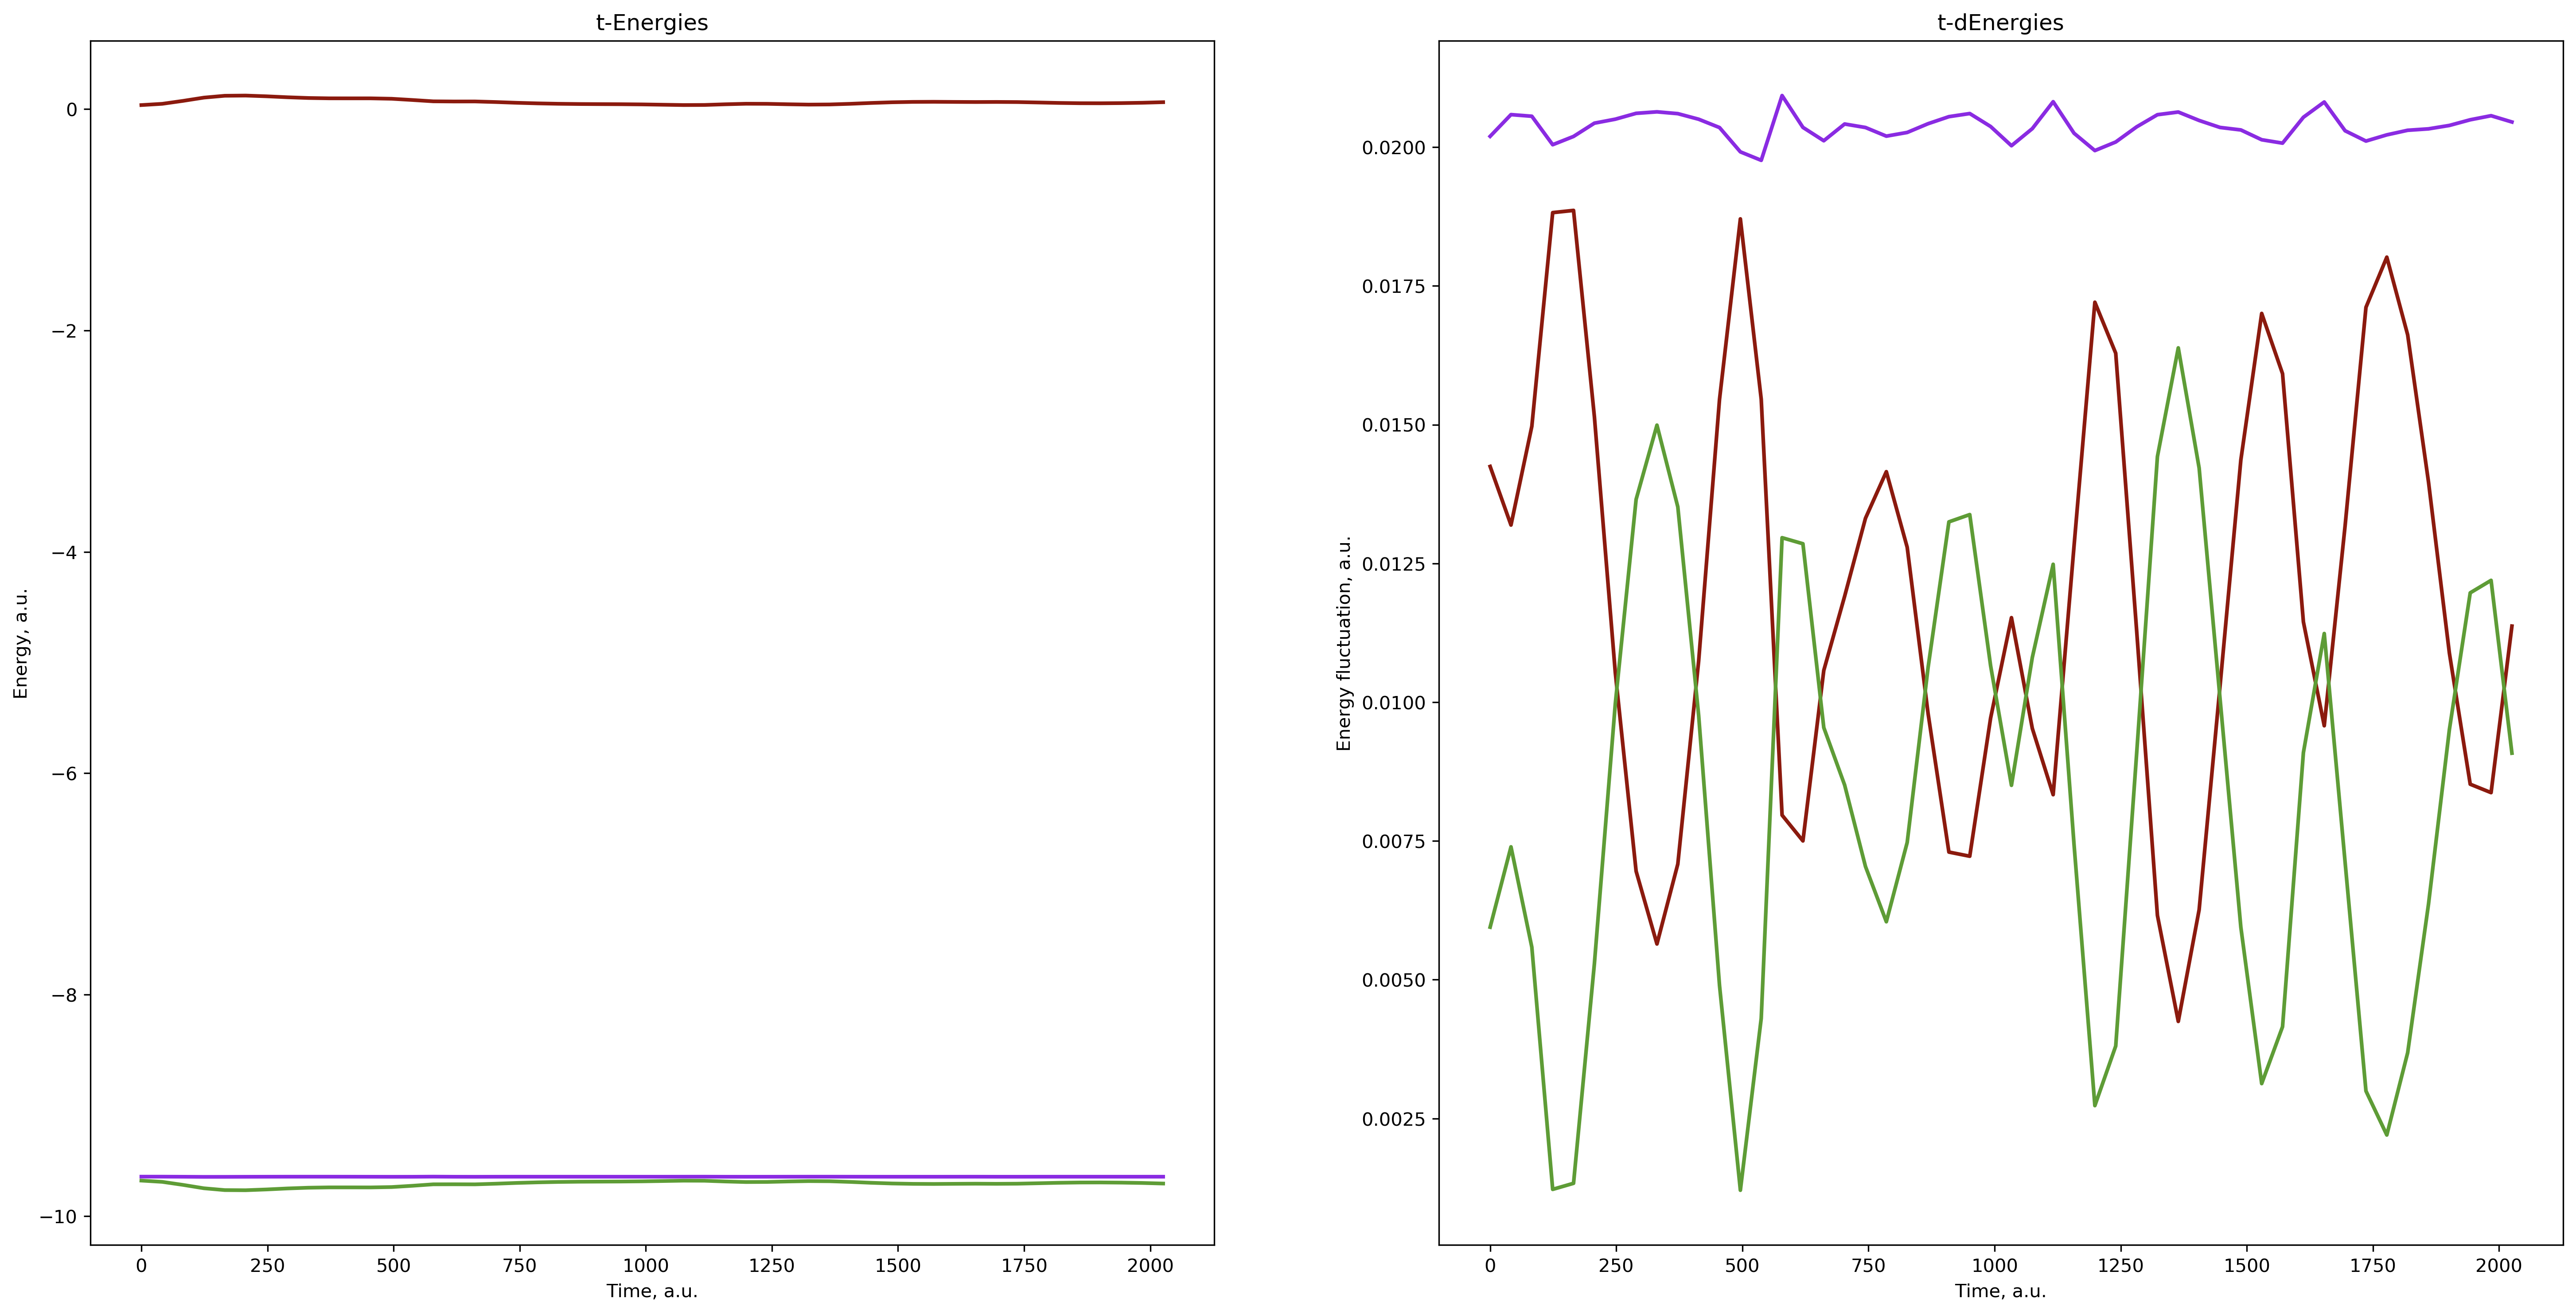

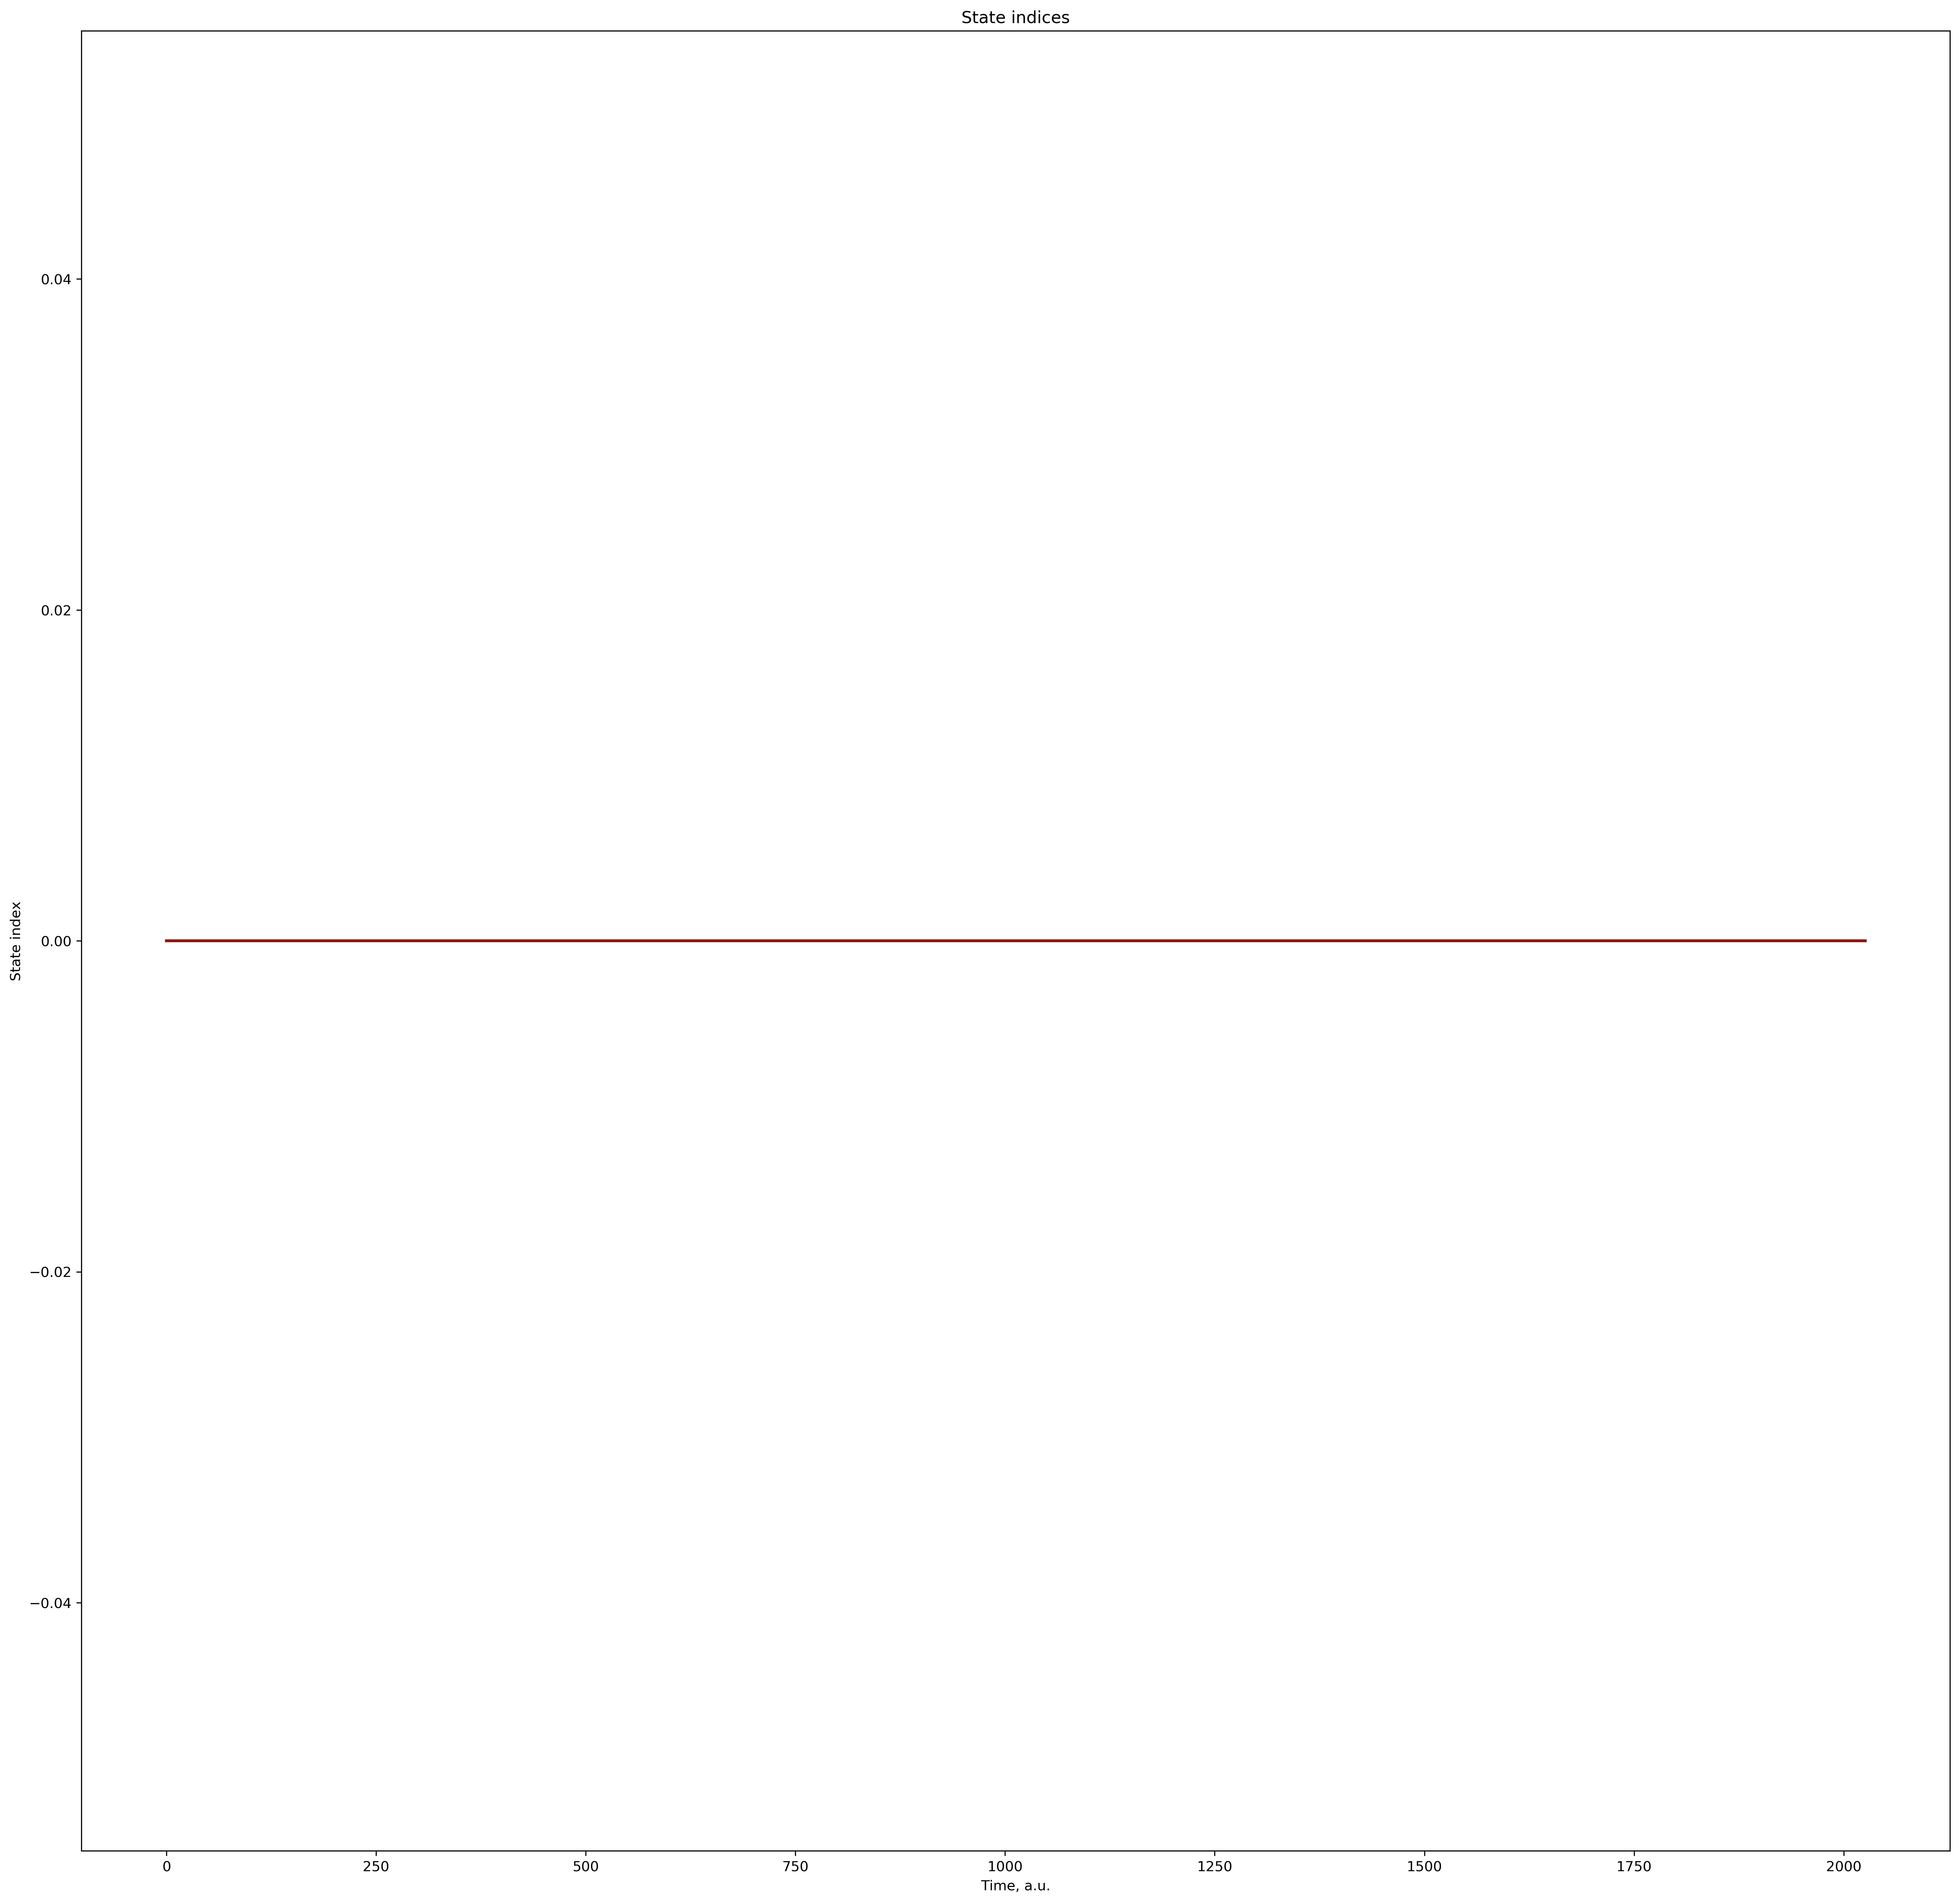

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


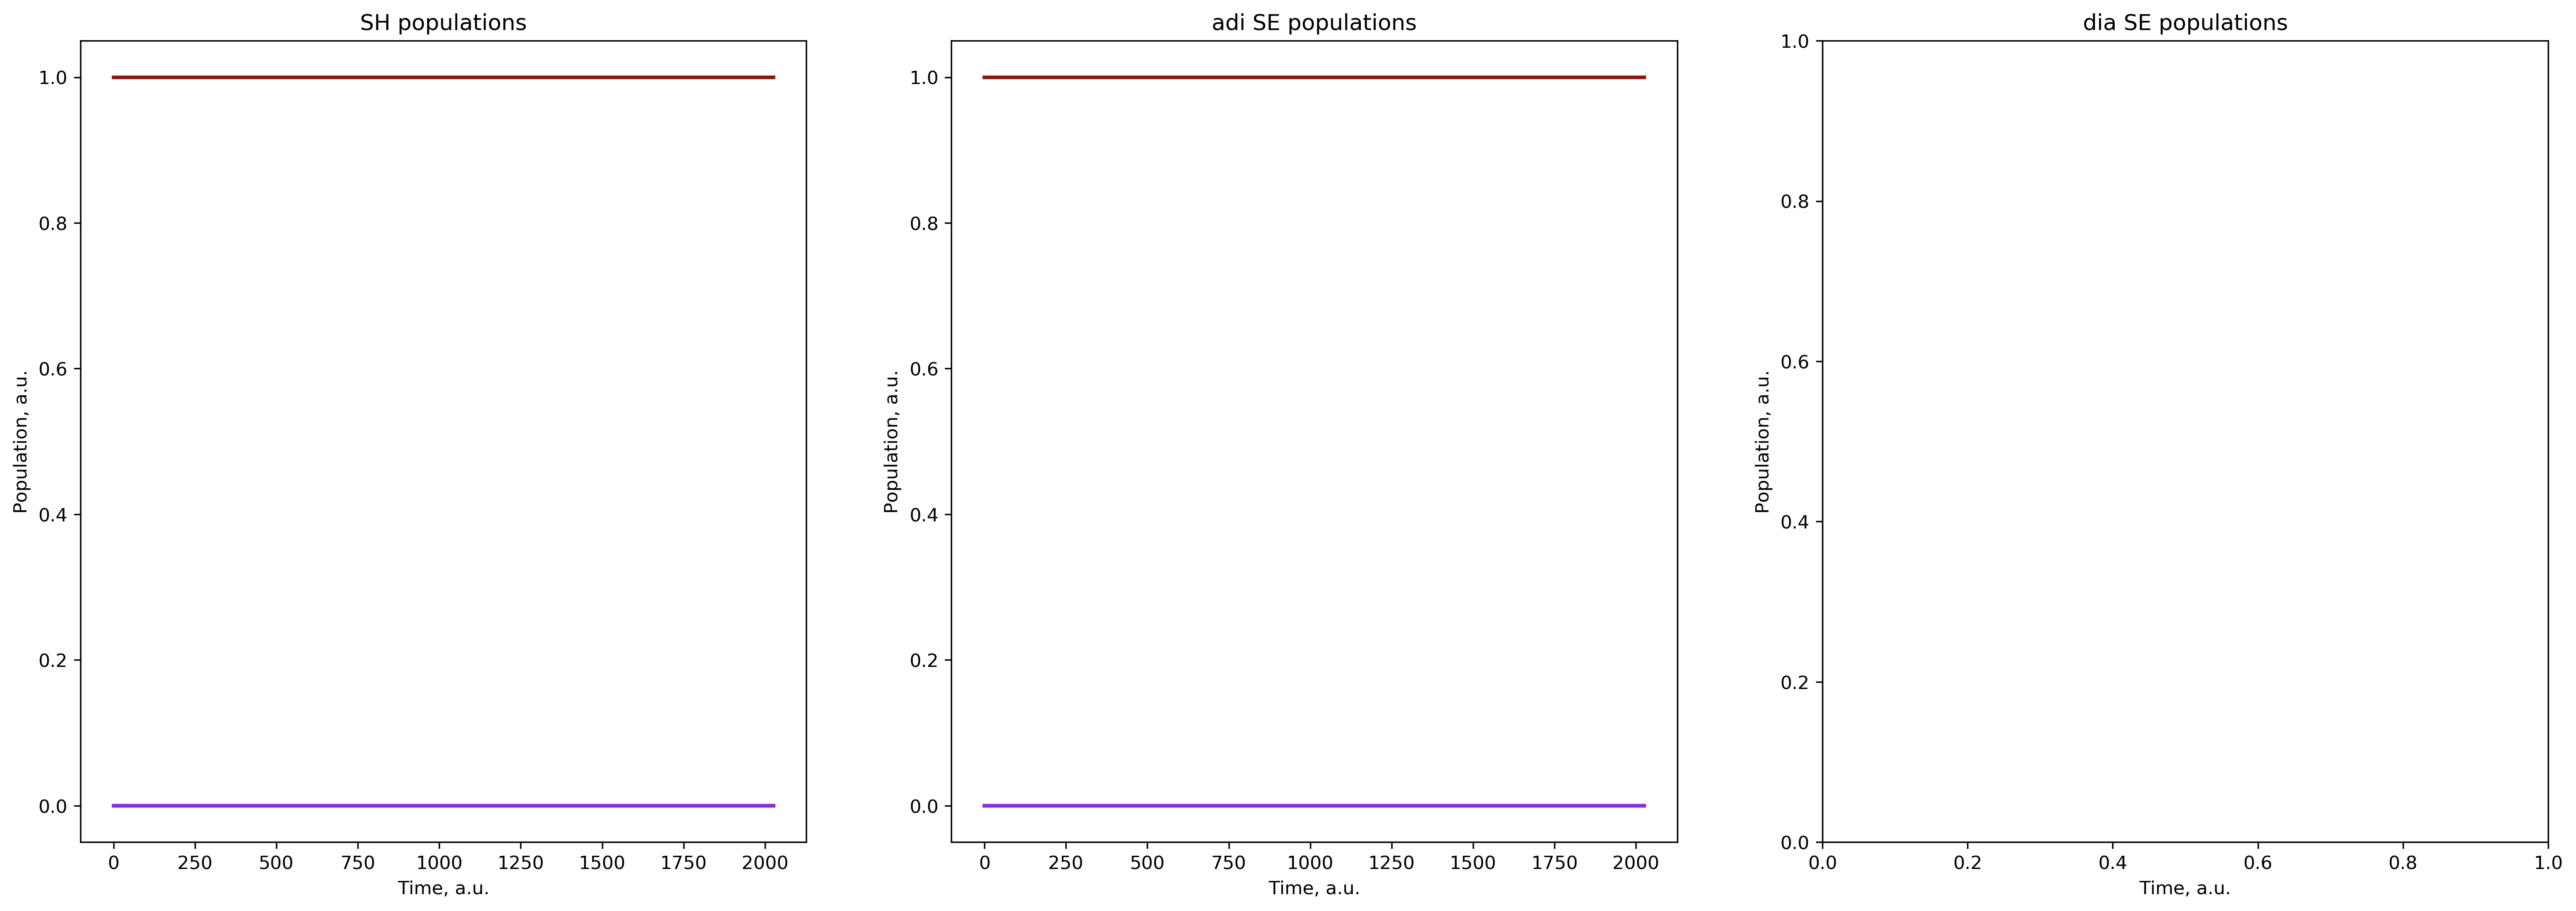

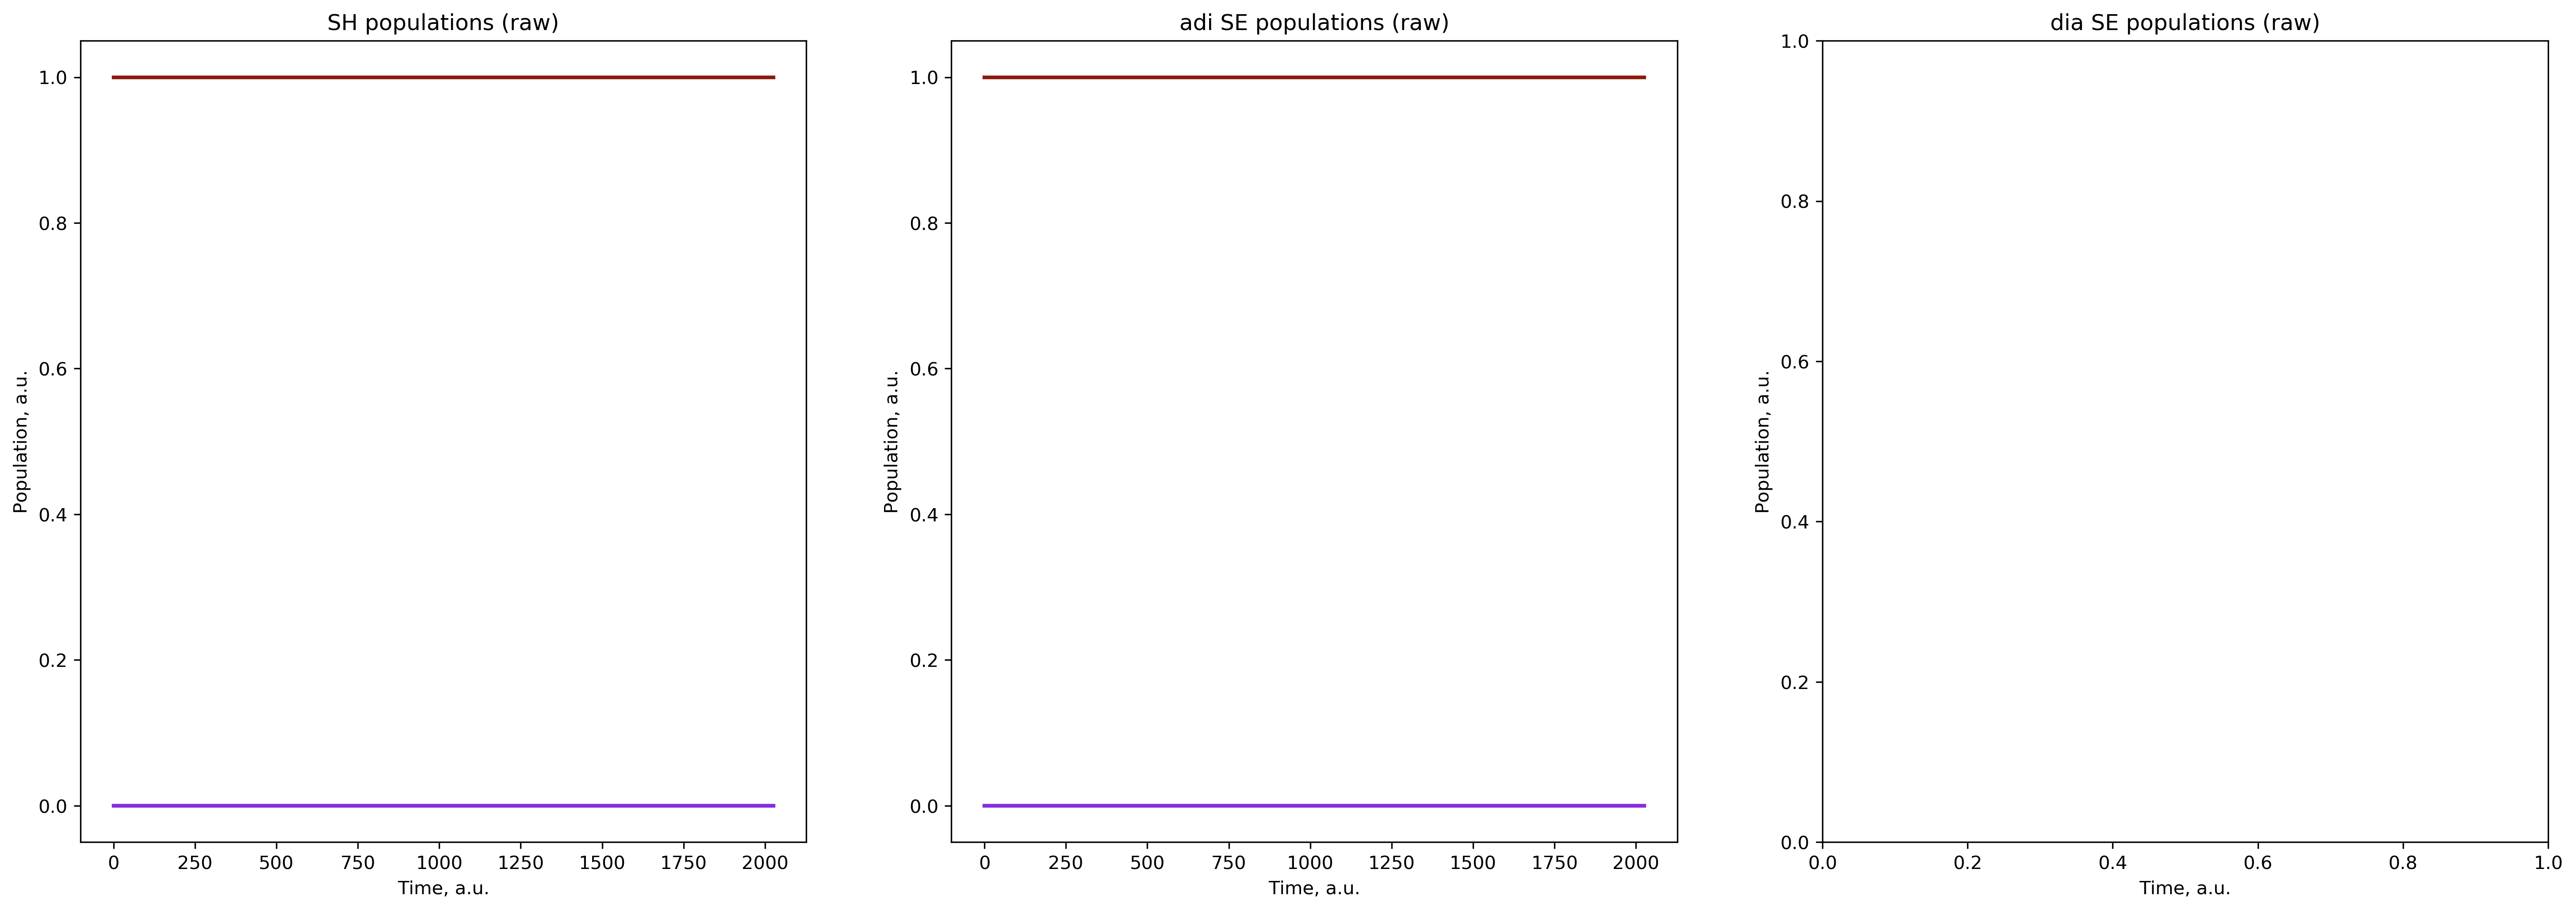

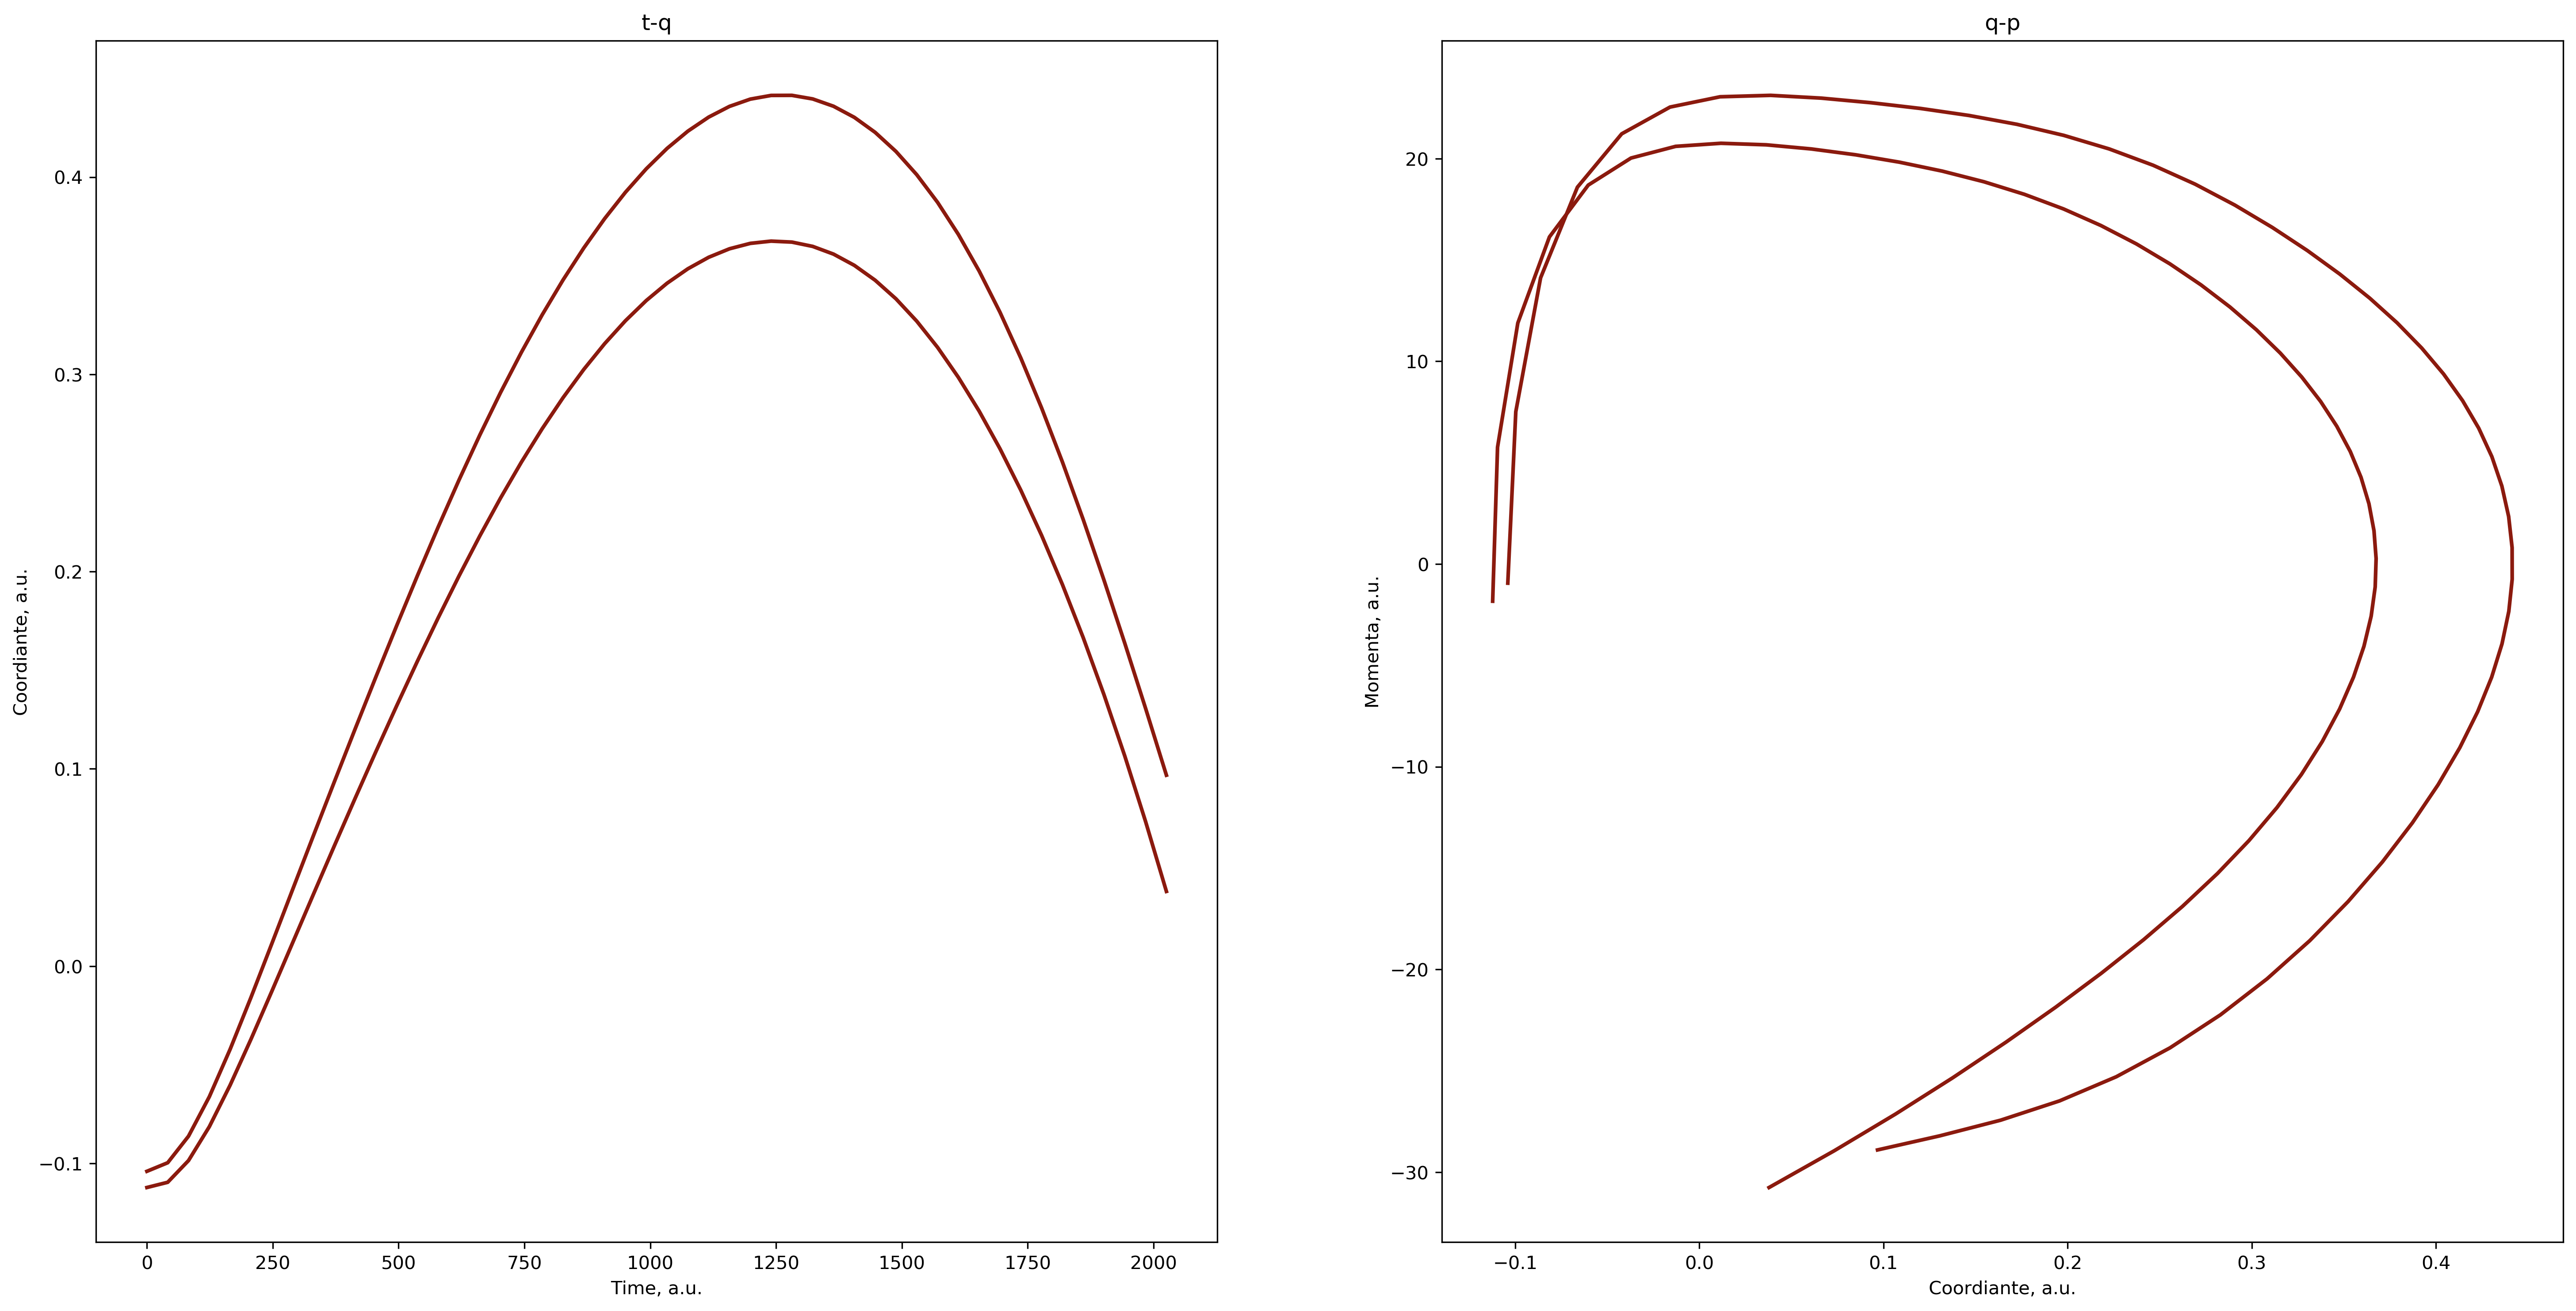

In [8]:
plot_prms = { "prefix":"out", "filename":"mem_data.hdf", "output_level":3,
              "which_trajectories":[0, 1], "which_dofs":[0],
              "which_adi_states":[0, 1, 2], "which_dia_states":[]              
            }
plot.plot_dyn(plot_prms)

<a name="gs-md-vis"></a> [Back to TOC](#TOC) | [Back to Adiabatic dynamics on the ground state](#gs-dynamics)
### 2.6. Visualize MD trajectories

In this section, we show how one can visualize the trajectories just comuted.

First, lets define an auxiliary function to read the coordinates from the HDF5 files generated by the `compute.run_dynamics` function. The purpose, input, and the output of this function are described in its docstring, so it shall be pretty self-explanatory.

Don't worry - if we need to re-use such a function elsewhere, it is now included in the `libra_py.dynamics.hsh.plot` module. 

The current one is here for if you want to play around with reading in the HDF5 files. For instance, note how we get access to the coordinates:

* we need to know the name of the data set "q"

* every data set has a subset called "data" - this is a standard practice in Libra, so we really access the coordinates via "q/data", not just "q"

* note the dimensions of this dataset - it is a 3D numpy array of the size: `nsteps x ntraj x ndof`. To learn more about the shapes of other saved data, refer to `save.init_tsh_data` function.

* the 3-rd dimension of the "q/data" dataset stores the DOFs - in this case the Cartesian components - so we need to unpack them to xyz format
<a name="hdf2xyz-ex1"></a>

In [9]:
def hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor=1.0):
    """
    This function creates a string containing an xyz-formatted trajectory (multiple geometries)
    from an HDF5 file produced by the `compute.run_dynamics` function

    Args:
        labels ( list of strings ): the labels of the atoms of the system, the labels are in a 
            specific order that corresponds to the atomic order in the system. The length of this 
            list should be `nat` - the number of atoms listed in the xyz header, even if not all of 
            them are listed in the input parameter `atoms`
        filename ( string ): the name of the HDF5 file that contains the geometry 
        snaps ( list of ints ): indices of the timesteps to be included in the xyz file being generated.
            This allows printing only simesteps of interest. 
        trajectories ( list of ints ): indices of the trajectories that we want to include in the xyz file. 
            This allows plotting many trajectories at once (in every frame).
        atoms ( list of ints ): indices of the atomic species to be printed out to the xyz files (e.g. to 
            eventually visualize). This allows for visualizing only a subset of atoms (e.g. a spatial region,
            a molecule, a group, etc.) of the main interest.
        unit_conversion_factor ( double ): the conversion factor to convert the data stored in the
            HDF5 file to the new units. Since `compute.run_dynamics` function stores all the information
            in the atomic units (Bohrs for the coordinates) and since the xyz files visualization works
            best in the Angstrom units, it is common situation to use the 
            `unit_conversion_factor = 1.0/units.Angst` conversion factor.
 
    Returns:
        string: the string representation of the xyz trajectory file that is made of the 
            provided input geomtries/trajectories/atomic labels 
    
    """
    
    natoms = len(atoms)  # the actual number of atoms to show 
    ntraj = len(trajectories)
    
    md_xyz = ""
    
    with h5py.File(filename, 'r') as f:
    
        for isnap in snaps:
            
            md_xyz = md_xyz + F"{natoms*ntraj}\nsnapshot {isnap}\n"
            
            for itraj in trajectories:
                for iatom in atoms:
                
                    x = f["q/data"][isnap, itraj, 3*iatom+0] * unit_conversion_factor
                    y = f["q/data"][isnap, itraj, 3*iatom+1] * unit_conversion_factor
                    z = f["q/data"][isnap, itraj, 3*iatom+2] * unit_conversion_factor
    
                    md_xyz = md_xyz + F"{labels[iatom] }  {x} {y} {z}\n"                    
    
    return md_xyz

And here is how we can use the function defined above:

* our system is an HFCO molecule, with atoms going like: F - 1-st, C - 2-nd, H - 3-rd, O - 4-th, so this is what defines the `labels` list

* the filename we are going to read is "out/mem_data.hdf"

* we request to print out all the integration timesteps - the `snaps` variable

* we can visualize several trajectories at once - so `trajectories = [0, 1]`. Visualizing many trajectories at once may look pretty weird sometimes, but it gives you a better story about the statistics of dynamical realization/samplings. It can be pretty cluttered too, but showing just 2 trajectories is okay.

* `atoms = [0, 1, 2, 3]` - we choose to show all the atoms of the molecule, but we could have chosed any sub-set of atoms.
<a name="hdf2xyz-ex2"></a>

In [10]:
labels = ["F", "C", "H", "O"]
filename = "out/mem_data.hdf"
snaps = list(range(0, 50))
trajectories = [0, 1]
atoms = [0, 1, 2, 3] # all atoms
unit_conversion_factor = 1.0/units.Angst # convert to Angstrom

xyz = hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor)

The finction `hdf2xyz` generated a string that contains an MD trajectory in the xyz format. We can print this string

In [11]:
print(xyz)

8
snapshot 0
F  -0.059401975947160686 0.6507629376837469 1.0425995287649727
C  -0.5290646015081348 0.8033241608502281 0.0764313560885694
H  0.18795700245857377 0.972381808248297 -0.7446804852339572
O  -1.7222372104243975 0.7845199448278541 -0.08961528304013454
F  -0.05505420698025201 0.6761281278340139 1.0324654431488571
C  -0.5202624180986312 0.8315602138509476 0.0702700716340836
H  0.1086267081073804 0.9933384163890918 -0.7681267256732129
O  -1.700946689992674 0.8050796801370007 -0.05965192576939352
8
snapshot 1
F  -0.05799868685784478 0.6506940961721214 1.0443657348894104
C  -0.5370404439105056 0.8061982734869755 0.05789216000410953
H  0.15615728074883348 0.9992725382287019 -0.7251419793243153
O  -1.7259869681575117 0.8027983186343355 -0.09673185991988775
F  -0.05275449396928686 0.6654218312451576 1.0322589943204576
C  -0.5182982150736205 0.8230417551635484 0.04229485253740189
H  0.08366162134282336 0.9234116781762619 -0.7383164481319412
O  -1.724134756006337 0.7983273935975933 -0.0

And finally, we can visualize the trajectory with the help of the py3Dmol extension

In [12]:
view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<a name="ex-dynamics"></a> [Back to TOC](#TOC)
## 3. Adiabatic dynamics on the excited state

In this section, we are going to do everything as above, but only using the excited state PES to drive the dynamics of the HFCO molecule.

With the help of various auxiliary finctions and Libra modules, we are going to make this section as compact as possible, but self-contained, so you can copy-paaste and use it as a template for other calculations.
<a name="init-elec-ex2"></a><a name="init-nucl-ex2"></a><a name="run_dynamics-ex2"></a>
<a name="adiabatic_md_interfaces_params-ex1"></a>

In [4]:
# Random numbers generator object
rnd = Random()

# Essential parameters
nstates = 3
ntraj = 2
istates = [0.0, 1.0, 0.0]


#====== Hamiltonian parameters =======
ham_params = { "labels":["F", "C", "H", "O"], "nstates":nstates,
               "dftb_exe":"/mnt/c/cygwin/home/Alexey-user/Soft/dftb/dftbplus-19.1.x86_64-linux/bin/dftb+",
               "xyz2gen_exe":"/mnt/c/cygwin/home/Alexey-user/Soft/dftb/dftbplus-19.1.x86_64-linux/bin/xyz2gen"
             }

#======= Molecular model and nuclear DOFs =======
# This is the input in Angstrom
mol = MATRIX(12,1)
mol.set(0,0, -0.04746);  mol.set(1,0,  0.65920);  mol.set(2,0,  1.04080)
mol.set(3,0, -0.51816);  mol.set(4,0,  0.81540);  mol.set(5,0,  0.06880)
mol.set(6,0,  0.15264);  mol.set(7,0,  1.00050);  mol.set(8,0,  -0.77170)
mol.set(9,0, -1.71206);  mol.set(10,0, 0.78520);  mol.set(11,0, -0.06860)
mol.show_matrix()

# The input is expected to be in Bohr, so lets convert:
mol *= units.Angst

# Initialize nuclear variables
ndof = mol.num_of_rows
k0 = data_conv.make_list(ndof, 10.0)  # force constants for initialization
init_nucl = {"init_type":3, "force_constant":k0, "ntraj":ntraj}
q0 = data_conv.matrix2list(mol)
p0 = data_conv.make_list(ndof, 0.0)
masses = [ 19.0, 19.0, 19.0,
           12.0, 12.0, 12.0,
            1.0,  1.0,  1.0,
           16.0, 16.0, 16.0
         ]
for index, item in enumerate(masses):
    masses[index] *= units.amu
    
q, p, iM = compute.init_nuclear_dyn_var( q0, p0, masses, init_nucl, rnd)


#======== Initialize electronic variables =========
init_elec = { "init_type":3, "nstates":nstates, "istates":istates, "rep":1,  "ntraj":ntraj  }
Cdia, Cadi, projectors, states = compute.init_electronic_dyn_var(init_elec, rnd)

# 
dyn_params = recipes.adiabatic_md_interfaces_params()
dyn_params["nsteps"] = 50
dyn_params["prefix"] = "hfco-ex1"
print(dyn_params)

res_ex = compute.run_dynamics(q, p, iM, Cdia, Cadi, projectors, states, 
                              dyn_params, 
                              DFTB_methods.run_dftb_adi, ham_params, rnd)

{'rep_tdse': 1, 'rep_ham': 1, 'rep_sh': 1, 'rep_lz': 1, 'tsh_method': -1, 'force_method': 1, 'nac_update_method': 0, 'rep_force': 1, 'hop_acceptance_algo': 0, 'momenta_rescaling_algo': 0, 'use_boltz_factor': 0, 'Temperature': 300.0, 'do_phase_correciton': 0, 'tol': 0.001, 'state_tracking_algo': 0, 'MK_alpha': 0.0, 'MK_verbosity': 0, 'entanglement_opt': 0, 'ETHD3_alpha': 0.0, 'ETHD3_beta': 0.0, 'decoherence_algo': -1, 'decoherence_times_type': 0, 'decoherence_C_param': 1.0, 'decoherence_eps_param': 1.0, 'dephasing_informed': 0, 'instantaneous_decoherence_variant': 1, 'collapse_option': 0, 'dt': 41.339396444811904, 'nsteps': 50, 'ensemble': 0, 'thermostat_params': {}, 'properties_to_save': ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'], 'hdf5_output_level': -1, 'pr

Plot the computed properties
<a name="plot_dyn-ex2"></a>

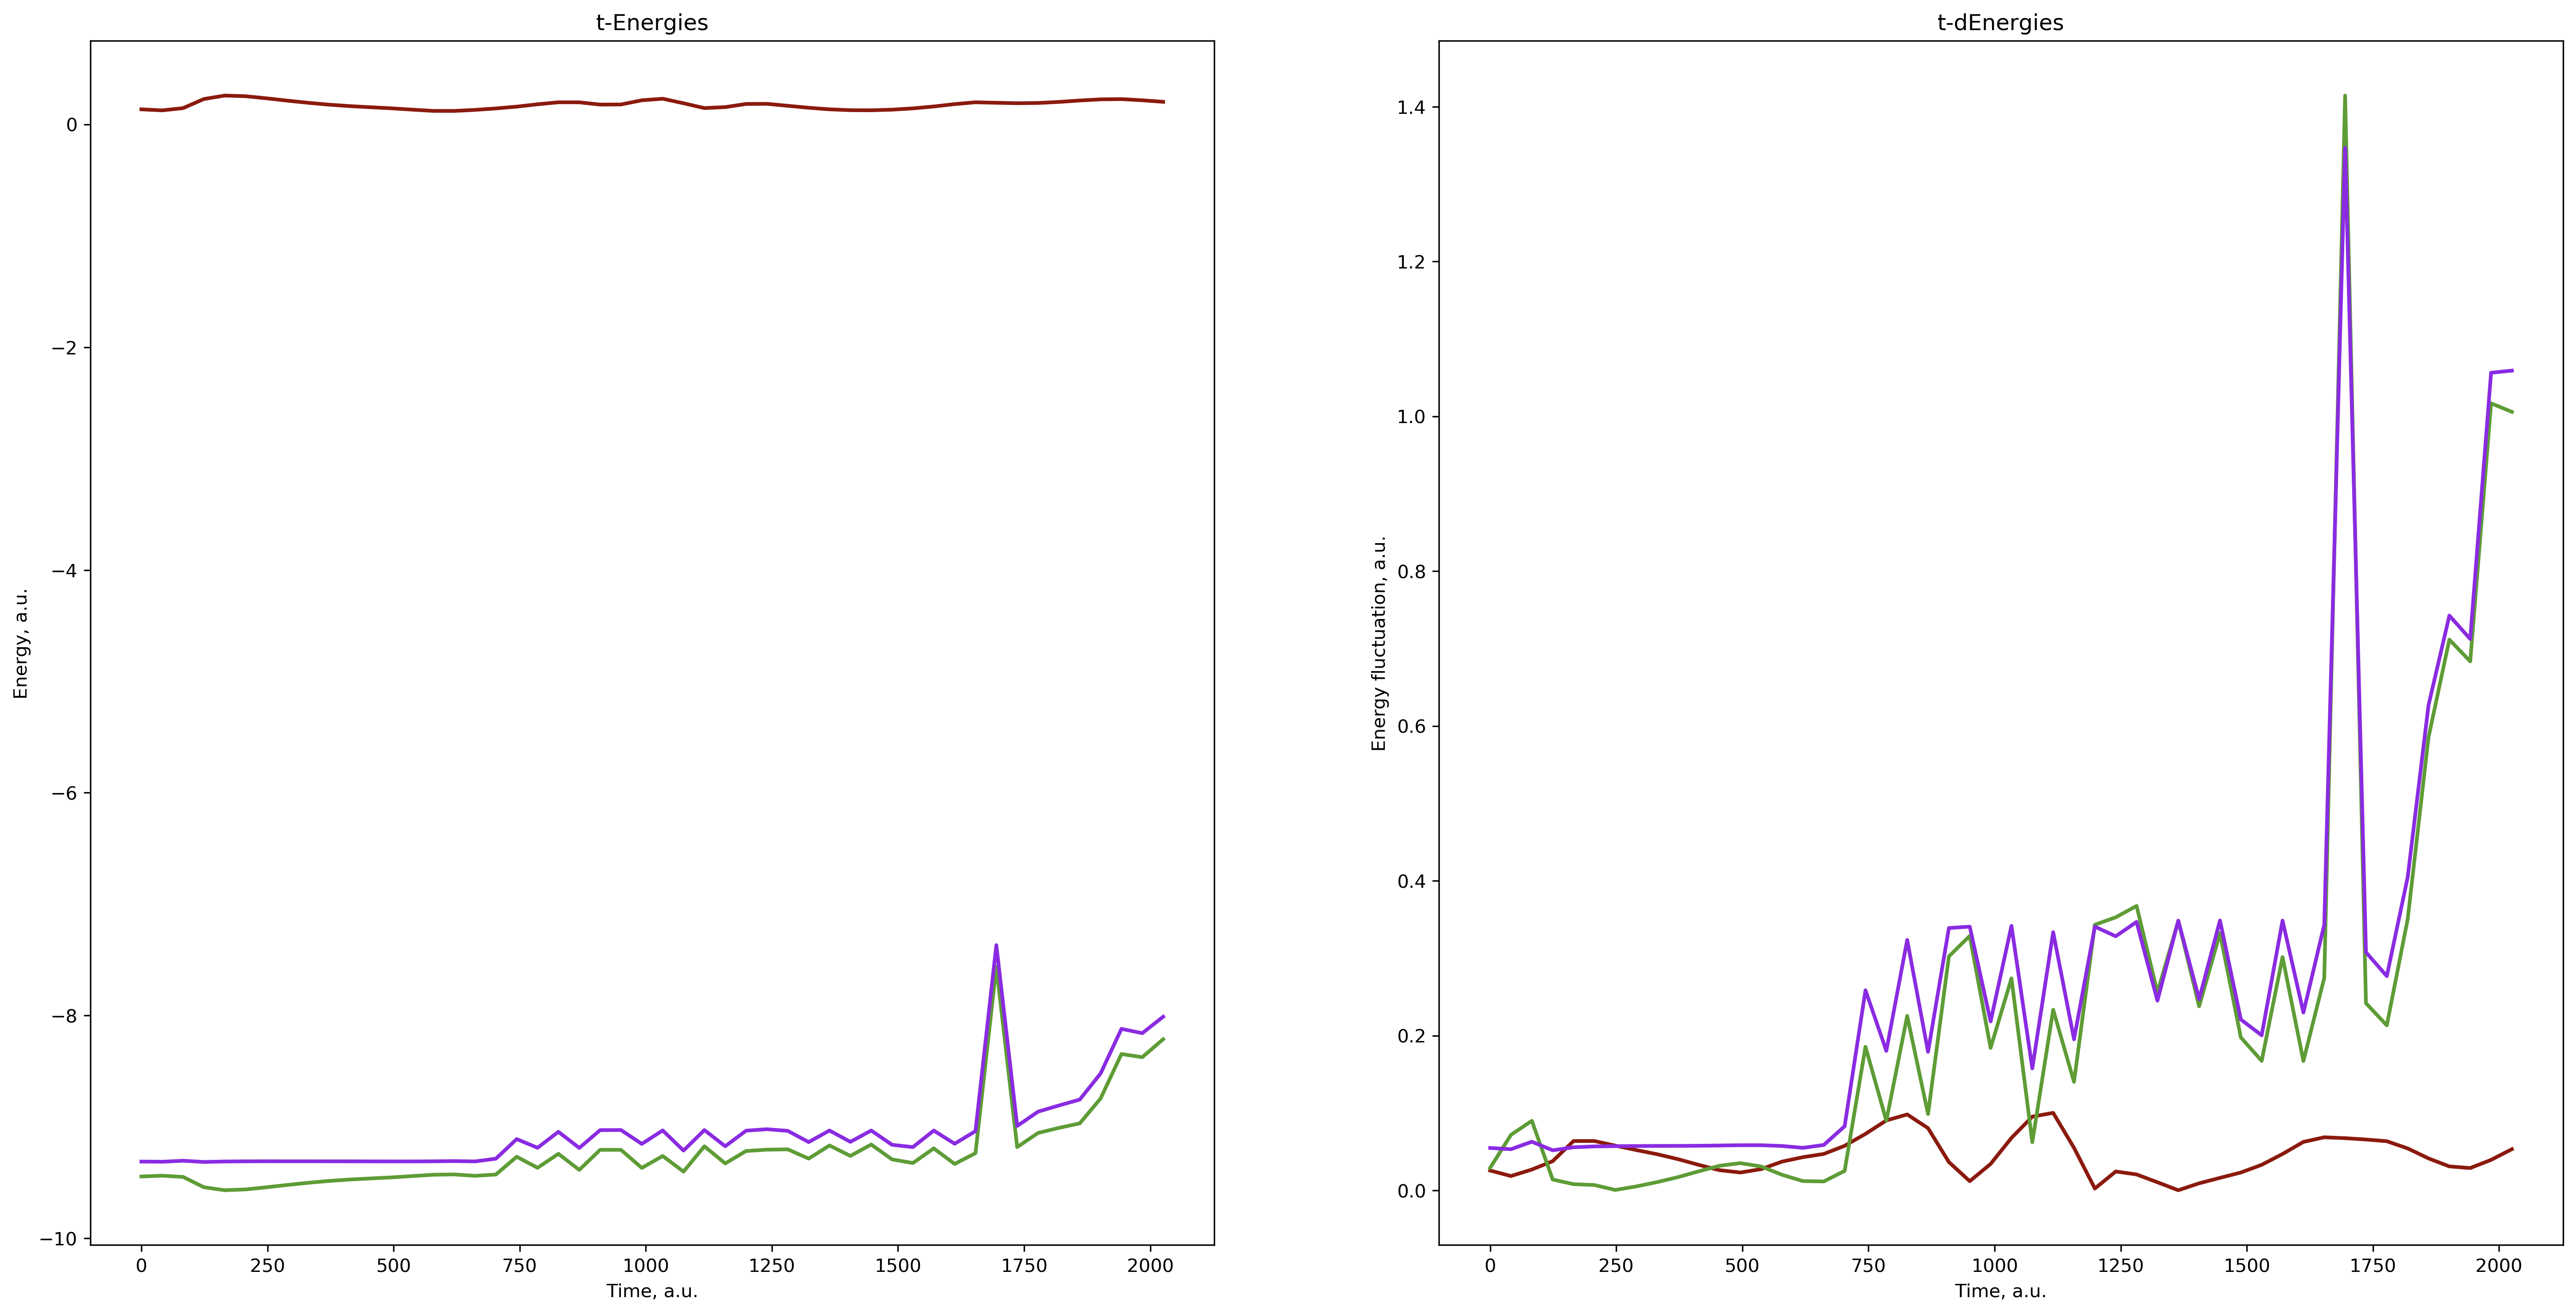

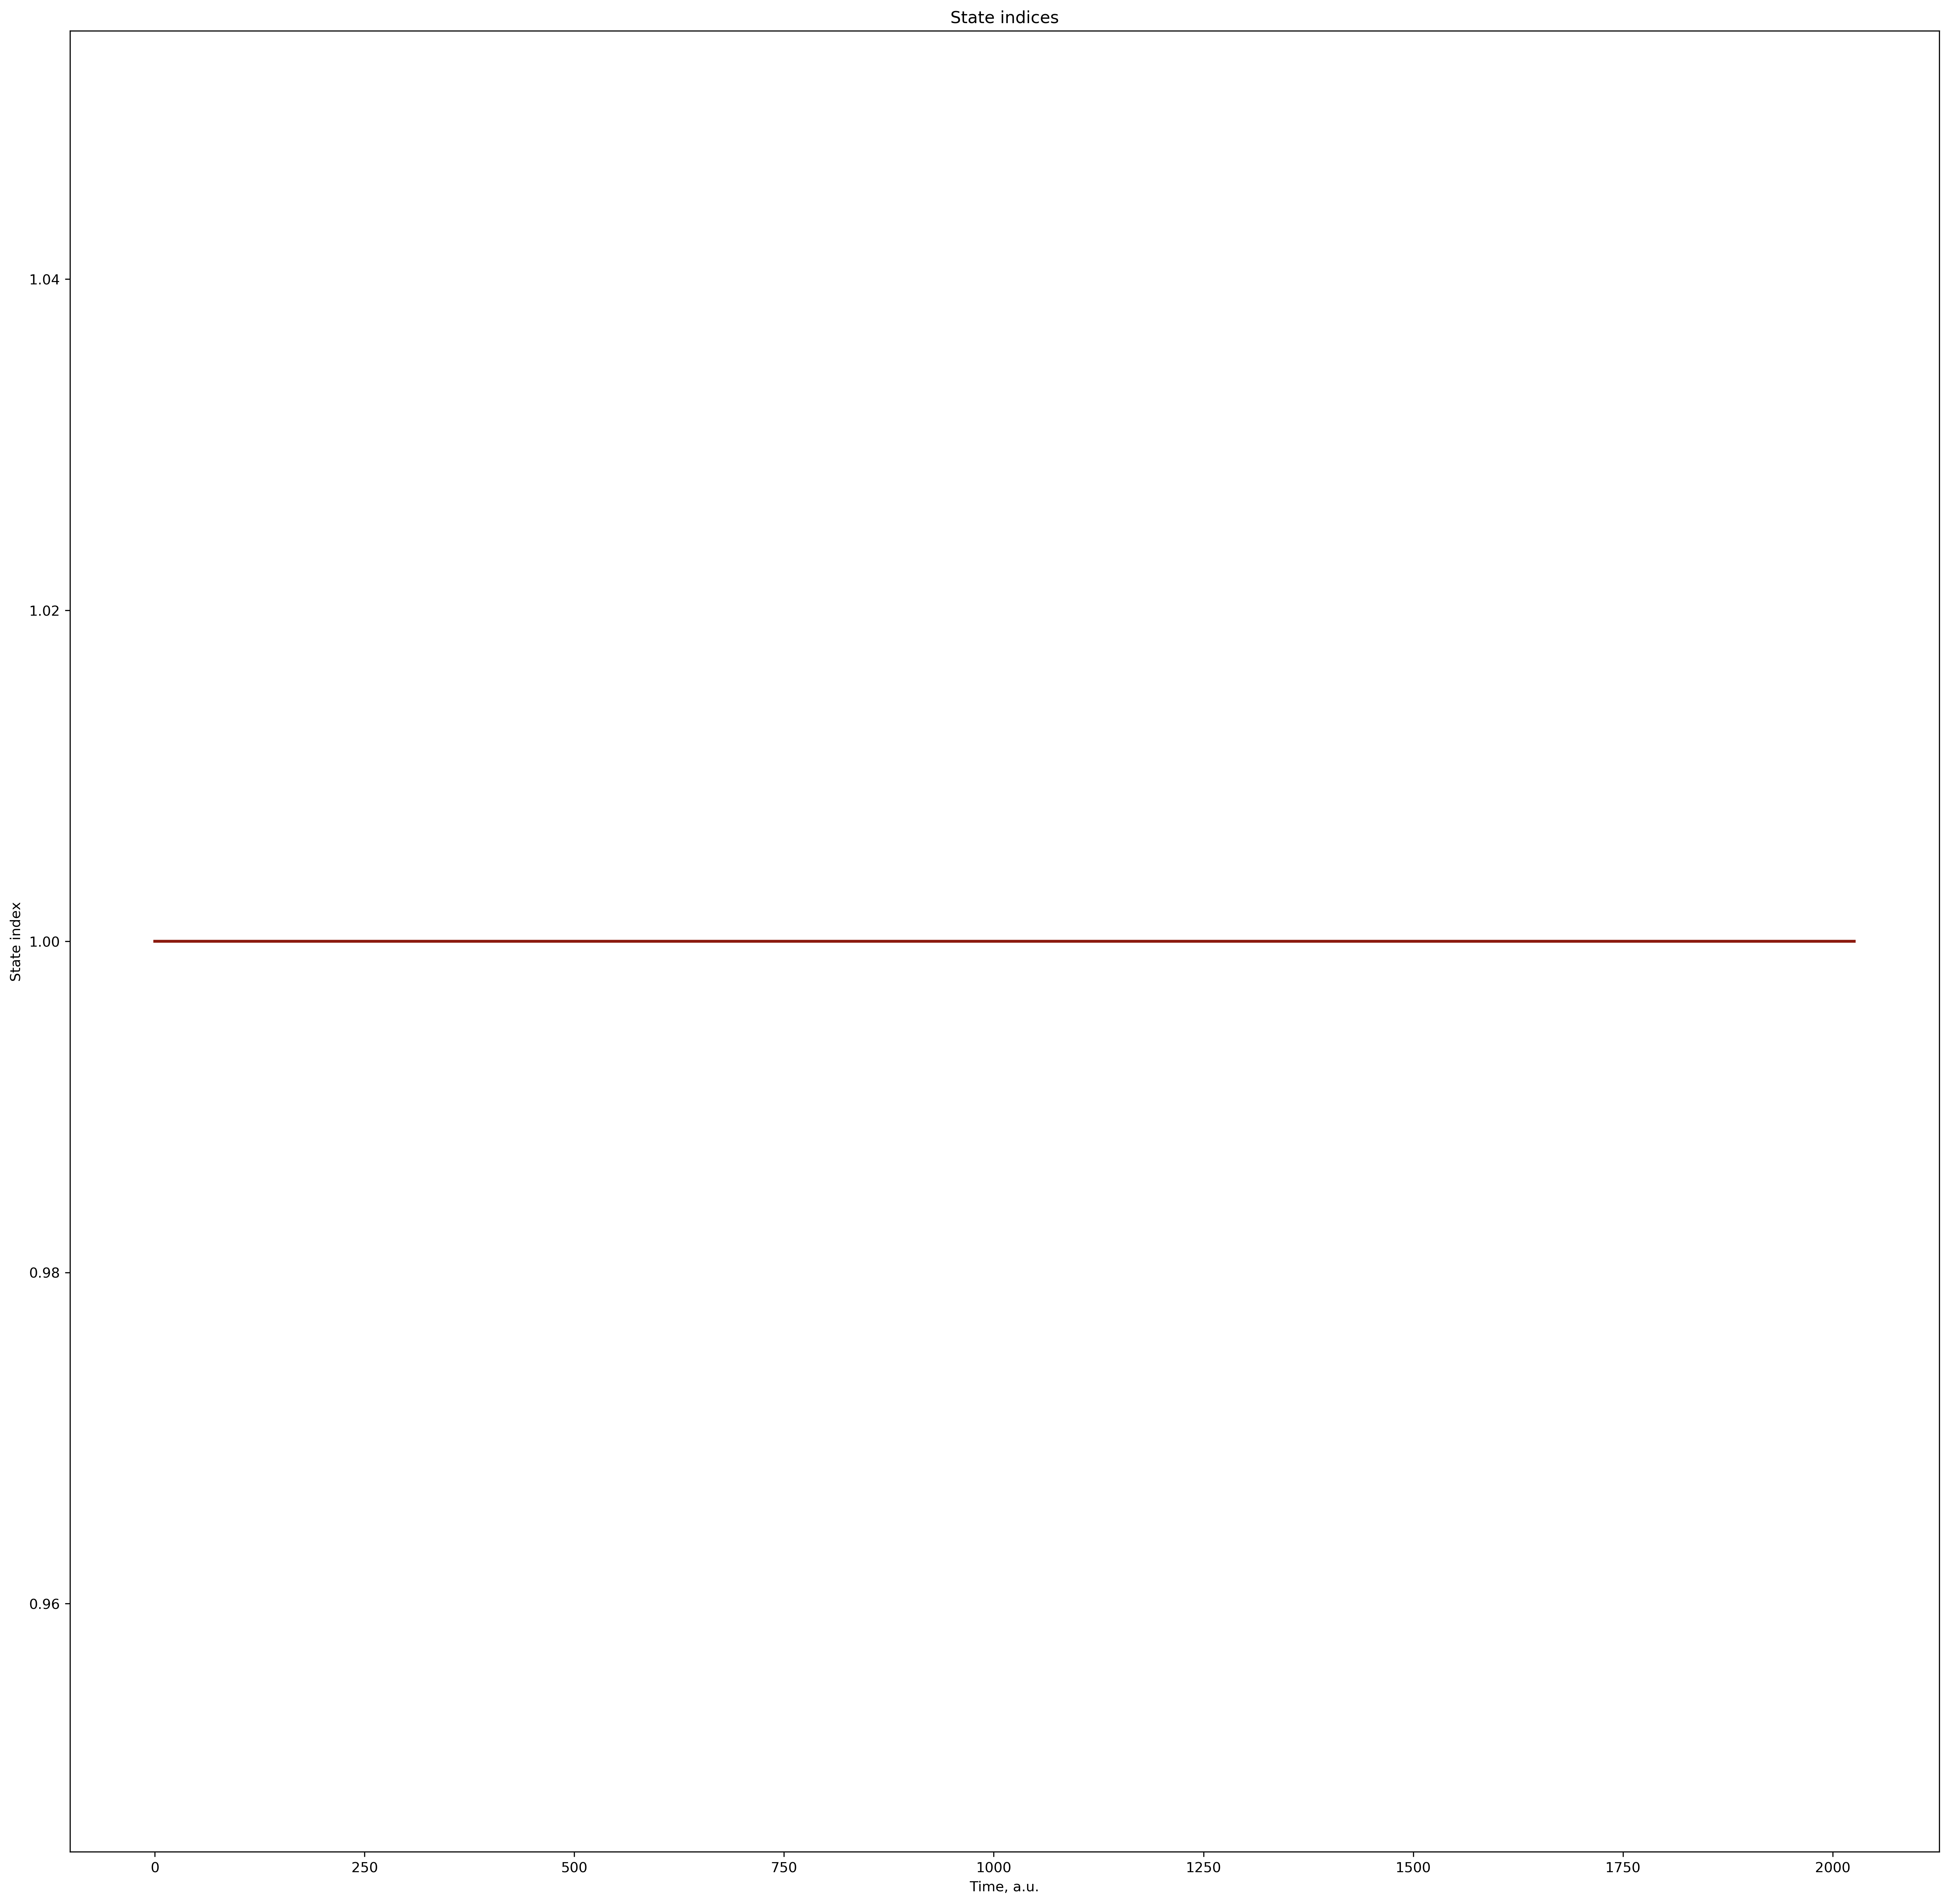

/home/alexey/miniconda2/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


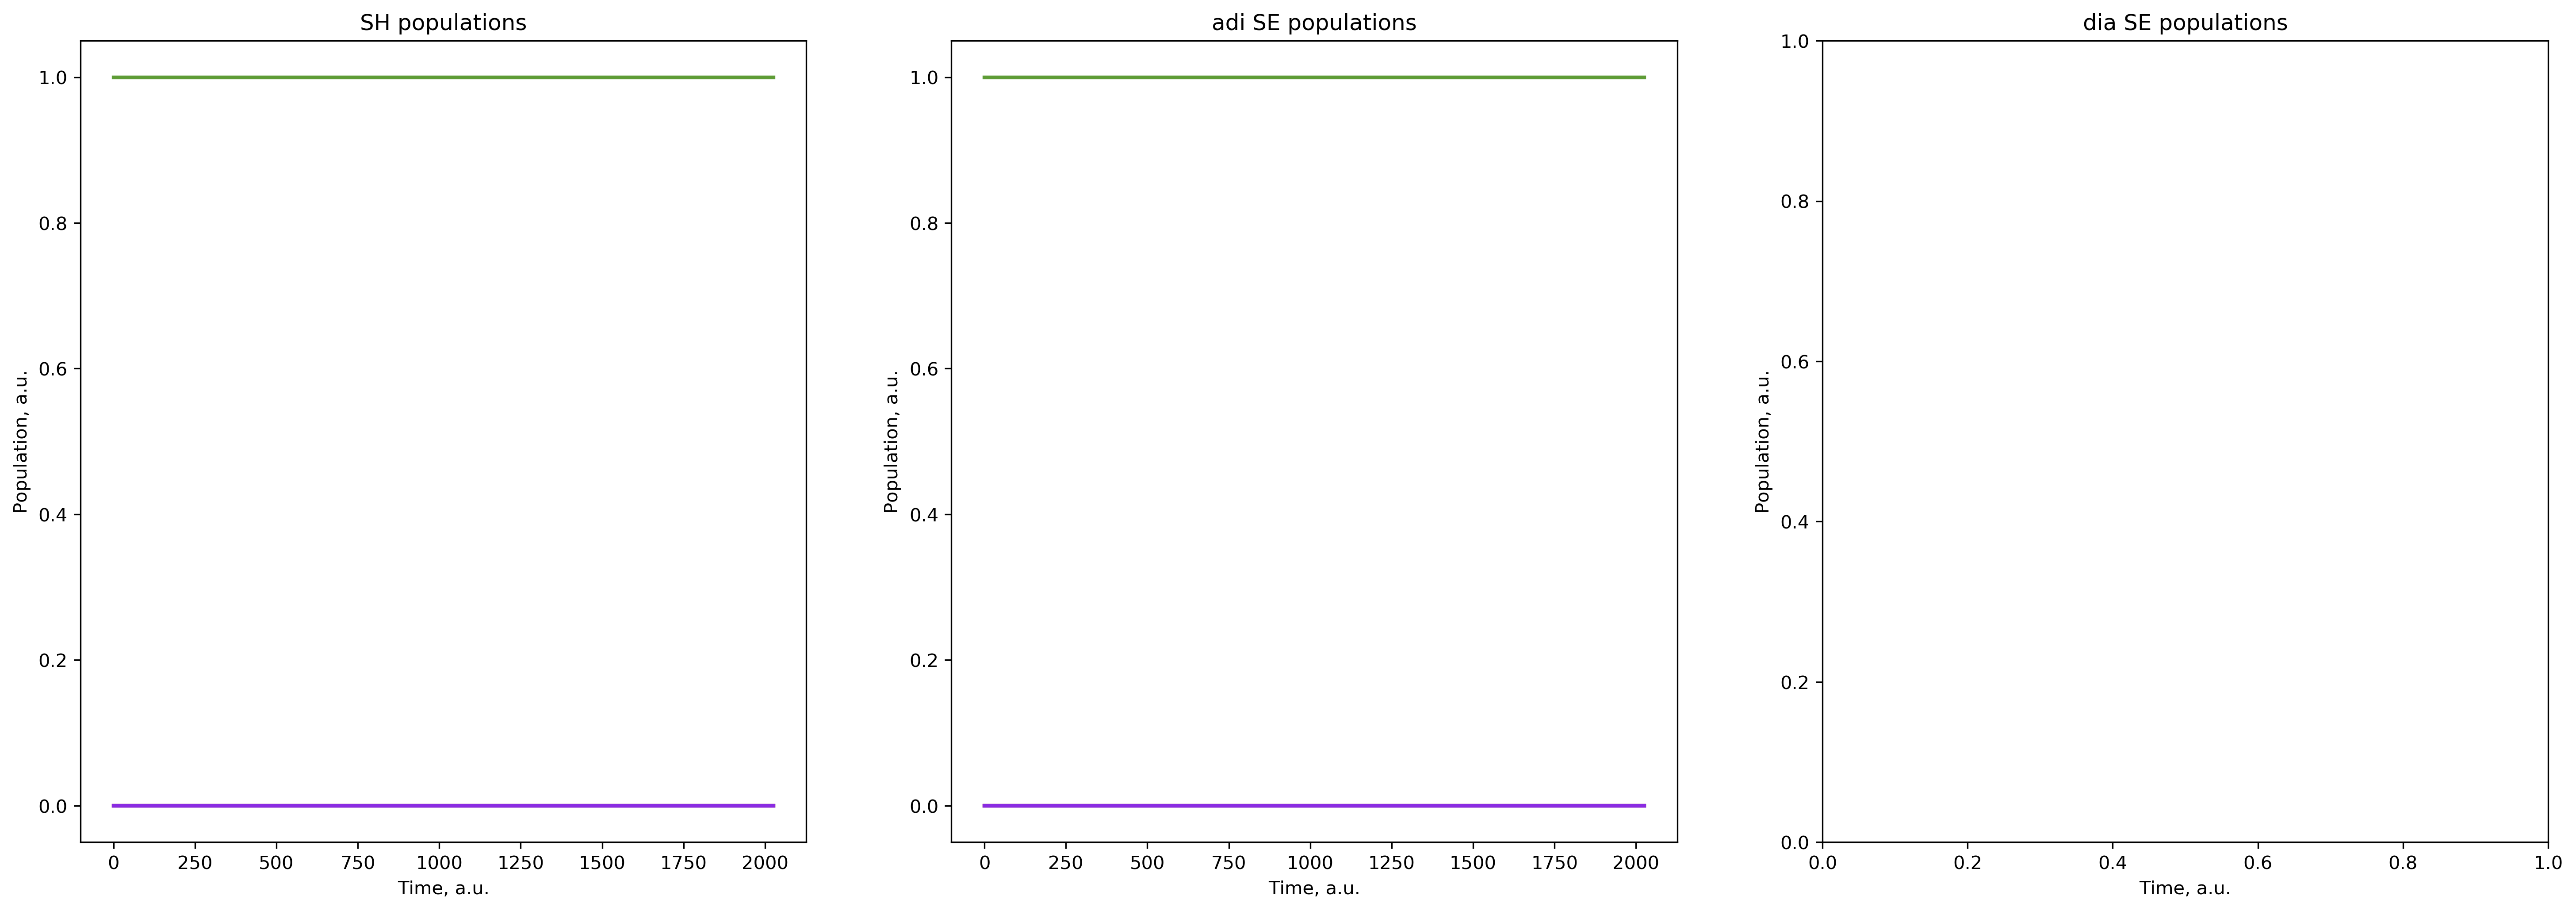

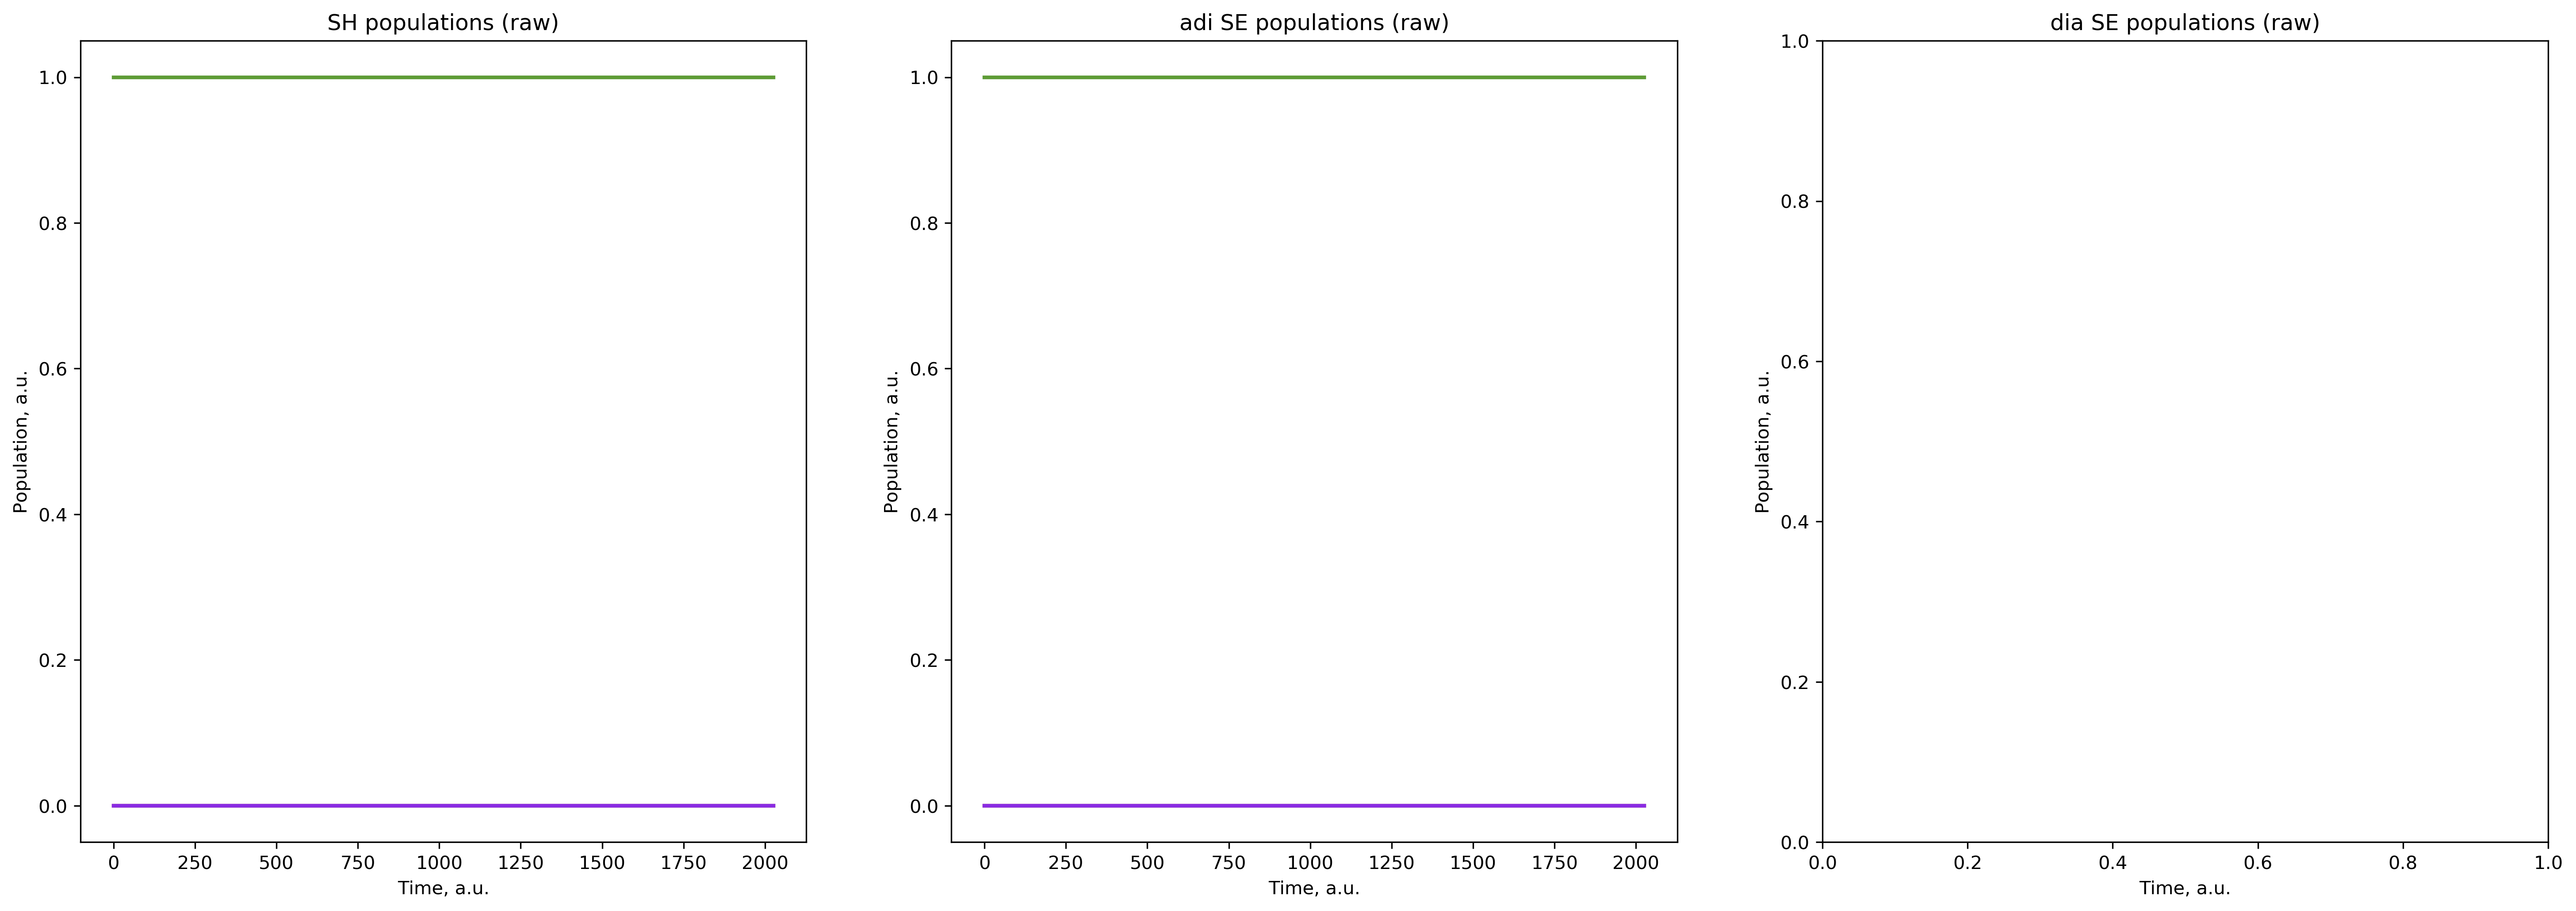

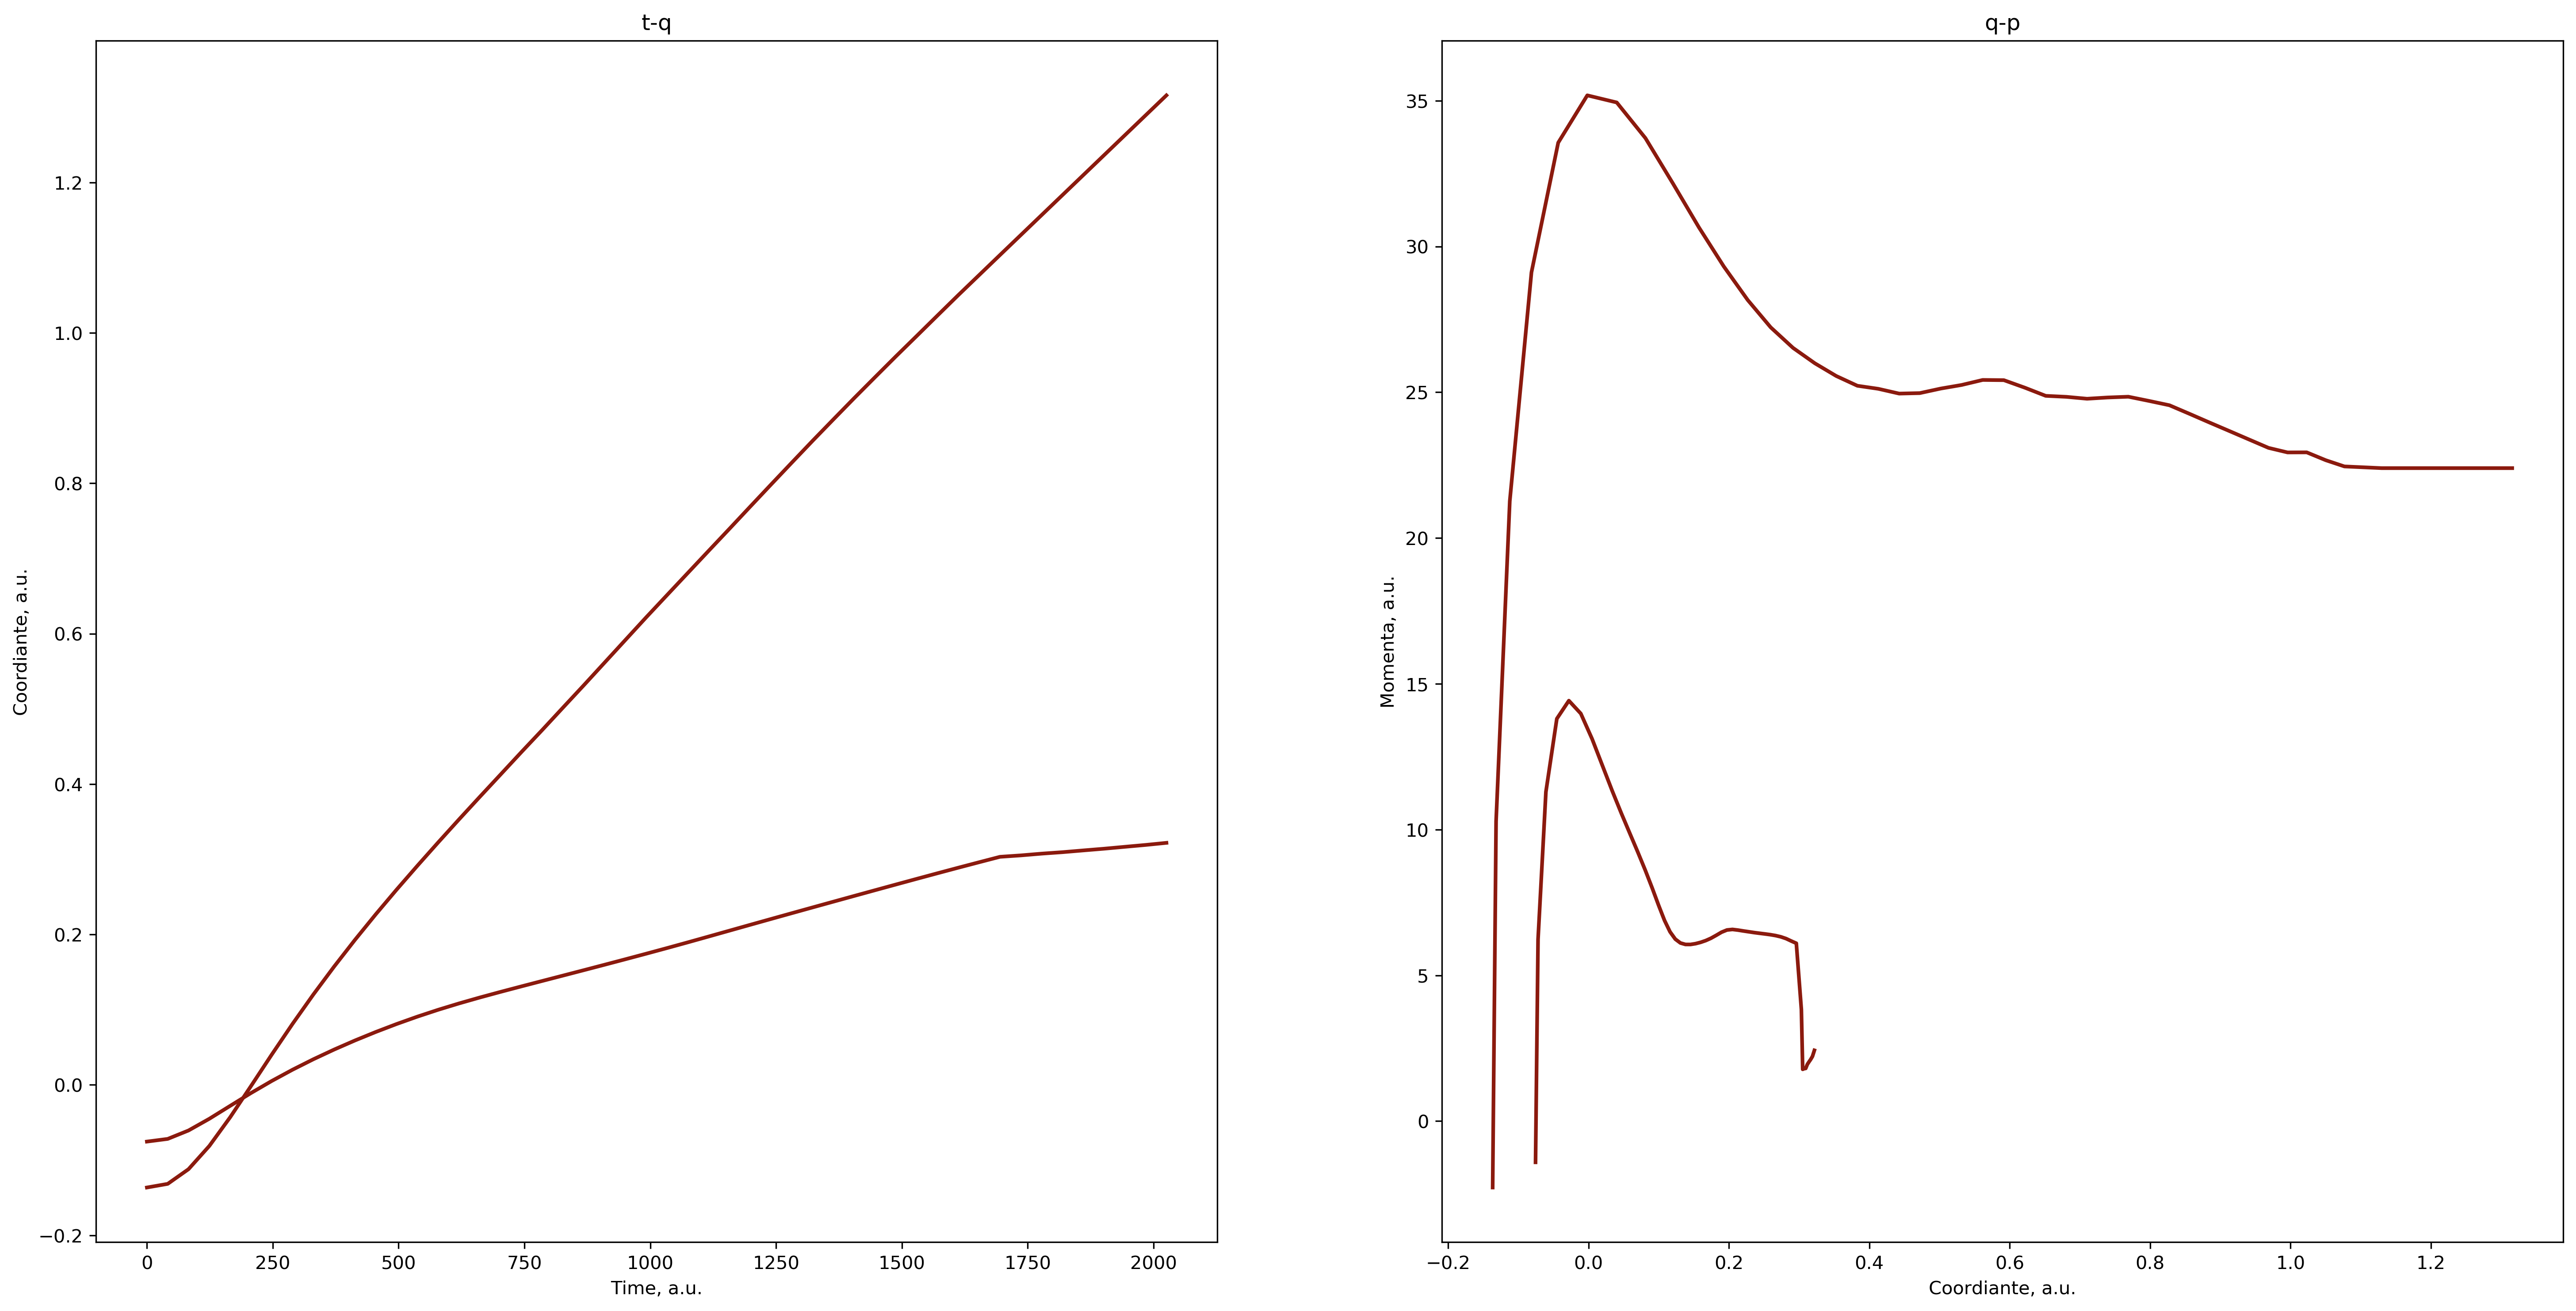

In [5]:
#========= plot the properties ============

plot_prms = { "prefix":dyn_params["prefix"], "filename":"mem_data.hdf", "output_level":3,
              "which_trajectories":[0, 1], "which_dofs":[0],
              "which_adi_states":[0, 1, 2], "which_dia_states":[]              
            }
plot.plot_dyn(plot_prms)

Now visualize the dynamics
<a name="hdf2xyz-ex3"></a>

In [6]:
#========= visualize the trajectories =============
labels = ["F", "C", "H", "O"]
prefix = dyn_params["prefix"]
filename = F"{prefix}/mem_data.hdf"
snaps = list(range(0, 50))
trajectories = [0, 1]
atoms = [0, 1, 2, 3] # all atoms
unit_conversion_factor = 1.0/units.Angst # convert to Angstrom

xyz = plot.hdf2xyz(labels, filename, snaps, trajectories, atoms, unit_conversion_factor)

view = py3Dmol.view(width=800,height=400)  
view.setBackgroundColor('0xeeeeee')                                     
view.zoomTo()                                                           
view.addModelsAsFrames(xyz, 'xyz')
view.setStyle({'sphere':{'colorscheme':'Jmol', }})                        
view.animate({'reps':0, 'loop':'forward', 'step':1})
view.show()  

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol